

<center><img src="https://www.tibco.com/sites/tibco/files/styles/banner_large/public/banner_images/TDV-Main-banner.jpg?itok=BkTvgztP" title="source: workable.com" /></center>

# Project 4: Predicting Data-Related Job Salary and Title from Job-Posting

With the advent of the technological and internet revolution, businesses, governments and individuals now have an ocean of data avaliable to them. Many are only just realising the true value of this information to not only provide insight to existing business products, services and processes, but to also identify drive new directions and market opportunities that would have been difficult, if not impossible, to identify. 

Indeed, data is has increasingly become the fundamental core of nearly all business decisions being made. For example, strategy will examine wider market trends and forecasts. Human resources will use online resources to identify the best talent and verify details. Marketing want to identify market segments to better target customers and drive sales. 

Due to this data-explosion, organisations and governments need to find people that can make sense of the data available to them. To this end, a whole swath of roles have now emerged. For example, there are Data Analysts, Data Scientists and Data Engineers, Machine Learning Engineers amongst many others. All of these roles emphasise different aspects of working with data. For example, Data Engineers are the data professionals who prepare the “big data” infrastructure to be analyzed by Data Scientists. They are software engineers who design, build, integrate data from various resources, and manage big data (https://cognitiveclass.ai/blog/data-scientist-vs-data-engineer). 

As part of this project, the objectives are:

1. **Question 1: Identify factors that predict the salaries of data-related roles**

2. **Question 2: Identify what distingushes between job catergories/titles**


### General Approach
To achieve these objectives, the following were identified as key to achieving success:

* **Scrape job posting from a jobs posting website**: the website selected for this was Indeed (https://au.indeed.com/?r=us)

    * Relevant Python libraries to achieve this include requests and BeautifulSoup. Requests facilitates sending HTTP/1.1 requests, which will be required for requesting information from Indeed. BeautifulSoup is a Python package for parsing HTML and XML documents. It creates a parse tree for parsed pages that can be used to extract data from HTML, which is useful for web scraping.
    
    * Need to inspect Indeed website and backwards engineer how job search operates to replicate this function in code for current purposes.
    
    * Build code to iterate through selected search criteria in specified location. 
    
    * **Search Criteria**:
        * Australia is the designated search location: selected as locally appropriate to client needs
        * Search terms selected: 'research+scientist', 'data+scientist', 'machine+learning+engineer', 'data+analyst'
   
   
* **Extract job related information into a Pandas dataframe for modelling**


* **Natural Language Processing (NLP)**: as job postings data will be in an unstructured form, data-cleaning will be vital to achieve project success. One approach will be NLP to extract key information/terms in job listings that predict salary and job categories/titles. 
    * Relevant Python libraries to achieve this inlcude nltk, spacy, and sklearn amongst others

### Import relevant project libraries 
All libraries relevant to the current project are imported here. 

In [661]:
#import relevant libraries for use
#Used for requesting website information
import requests
#Import BeautifulSoup library for pulling data out of HTML and XML files
from bs4 import BeautifulSoup
import lxml
#Imports Regular Expression library
import re

#Imports other relevant libraries for use
import pandas as pd
import numpy as np
import time
from random import random
from datetime import datetime
import os
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Imports sklearn related libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge,Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import eli5

#Import relevant NLP Libraries
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from textblob import TextBlob, Word
import nltk
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud, ImageColorGenerator

#Importing f_regression to to obtain p values associated with coefficients
from sklearn.feature_selection import f_regression

%matplotlib inline

## Webscrapping Indeed.com
The first section covers the approach taken to extract job listings from Indeed.com. 

<center><img src="https://i2.wp.com/www.inzejob.com/wp-content/uploads/2016/06/indeed.png?fit=750%2C200&ssl=1" title="source: workable.com" /></center>


From investigation of way the search works, we can see that search strings result in logical structures emerging as the web-address that should facilitate automation of searching through specific jobs. For example, the image below is the URL when searching for data scientist in Australia.

<br><center><img src="./images/indeed_search_bar.jpg" title="Indeed Search Criteria" /></center>

As can be seen base (i.e. first page) URL when searching for "data scientists" in "Australia" is https://au.indeed.com/jobs?q=data+scientist&l=Australia. Here we can see the job query is represented by the string query /jobs?q=data+scientist, with the search term "data+scientist" clearly embedded as a query for the database. We can also see that if a user requests specific locations (in this case Australia), then other search criteria are appended to this in some format following "&" such as for location, this seems to be from the format "&l=" with l probably meaning location. We should be able to, therefore, work backwards to identify how different search criteria (e.g. location, radius, pages to return etc) influence the search string in a way that Indeed.com database will understand. 

### Search Criteria

In [411]:
#1. The User-Agent request header is a characteristic string that lets servers and network peers identify the application, 
#operating system, vendor, and/or version of the requesting user agent. 
#Below will be used as the current user-agent to send to websites when crawling to help represent actual user interactions with website and reduce
#the liklihood of being identified as a "bot" resulting in declined requests.
headers = {"User-Agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36'}

In [956]:
#2. This the defines the job titles to search through. The job should be in a search string accepted by Indeed.com.
#In particular, spaces must be separated by a + to represent that the search should look for each individual word.
#For current purposes, I have specified four search strings here but more can be specified if required. 
job_titles = ['research+scientist',
              'data+scientist',
              'machine+learning+engineer',
              'data+analyst',
#               'junior+data+analyst',
#               'senior+data+analyst',
#               'data+analyst+people',
#               'data+science+researcher',
#               'senior+data+scientist',
#               'junior+data+scientist',
#               'data+science+manager'
             ]

#location to search. Must be a search string that is accepted by Indeed.com otherwise will fail.
#For current purposes, I have specified Australia as is most relevant for current purposes and facilitates working
#on the job market in a single country. 
#Note at present, this only will accept one location per search. If multiple locations are required, then you will need
#to run multiple search locations one at a time. 
location = "Australia"

#km for job search radius
#Note currently this is **NOT** working but should be a relatively simple fix in the base URL formatting 
job_search_radius = 100

#number of jobs to return per page
#This should be set to 50, which is the max indeed.com allows
#and reduces the number of times requests are being made, which should help with reducing impact on Indeed's servers.
return_per_page= 50

#Set search criteria for salary. 
#Note currently this is **NOT** working but should be a relatively simple fix in the base URL formatting
salary = "$0"

#Specify number of jobs to scrape before stopping
#Note currently this is **NOT** working but should be a relatively simple fix below
stop = 1000

In [957]:
#3.This generate a list of base_urls for each job_title to search through based on the specific search criteria specified above
#There should be one base URL for each job. 
base_job_title_url_list = []

for job_title in job_titles:
    base_job_title_url_list.append('https://au.indeed.com/jobs?q=%s&l=%s&radius=100&limit=50&start=0' %(job_title, location))
base_job_title_url_list

['https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=0',
 'https://au.indeed.com/jobs?q=data+scientist&l=Australia&radius=100&limit=50&start=0',
 'https://au.indeed.com/jobs?q=machine+learning+engineer&l=Australia&radius=100&limit=50&start=0',
 'https://au.indeed.com/jobs?q=data+analyst&l=Australia&radius=100&limit=50&start=0']

In [958]:
#4. This iterates through each of the base_job_title_urls to identify the number of specific job postings that 
#will need to be iterated through in a later step and then appends these to a dictionary that will form the basis
#of collecting and storing all job information. 
search={}

for i,base_url in enumerate(base_job_title_url_list):
    time.sleep(random()*2) #<--Sleep in used to reduce multiple requests in close sequence.  
    
    #To verify where processing is, information is printed to screen. 
    print("\n-------")
    print("Finding number of pages to iterate for search term:",job_titles[i])
    print("Base Url located at:",base_url)
    res = requests.get(base_url, headers=headers)
    print("Response from website:",res.status_code)
    soup_the_page = BeautifulSoup(res.content,features='lxml')
    pages_search_return = soup_the_page.find_all('span',{'class': 'pn'})
    pages_to_search = len(pages_search_return)
    total_jobs = str(soup_the_page.find('div',{'id': 'searchCountPages'}))
    
    #This short if/else is to capture situations where no jobs are listed.
    if total_jobs == "None":
        total_jobs = 0
    else:
        total_jobs = [int(s) for s in total_jobs.replace(',','').split() if s.isdigit()][1]
    
    print("Pages to Search:",pages_to_search)
    print("Total jobs listed:", total_jobs)
    
    #This is where the extracted information is appended to the search dictionary for use in later processing. 
    search.update({job_titles[i]: {'Search Location': location,
                                   'Total jobs':total_jobs,
                                   'Pages to Search':pages_to_search,
                                   'Base Url':base_url,
                                   'Website Response': res.status_code}})
    print("Appended to the Search dictionary")


-------
Finding number of pages to iterate for search term: research+scientist
Base Url located at: https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=0
Response from website: 200
Pages to Search: 5
Total jobs listed: 274
Appended to the Search dictionary

-------
Finding number of pages to iterate for search term: data+scientist
Base Url located at: https://au.indeed.com/jobs?q=data+scientist&l=Australia&radius=100&limit=50&start=0
Response from website: 200
Pages to Search: 11
Total jobs listed: 638
Appended to the Search dictionary

-------
Finding number of pages to iterate for search term: machine+learning+engineer
Base Url located at: https://au.indeed.com/jobs?q=machine+learning+engineer&l=Australia&radius=100&limit=50&start=0
Response from website: 200
Pages to Search: 7
Total jobs listed: 382
Appended to the Search dictionary

-------
Finding number of pages to iterate for search term: data+analyst
Base Url located at: https://au.indeed.com/

In [959]:
#5. This is just a check to see if information has been correctly added to Search Dictionary from the above search
search
#As can be seen, the dictionary has been correctly appended with the information and base URL, which will be used for future processing. . 

{'research+scientist': {'Search Location': 'Australia',
  'Total jobs': 274,
  'Pages to Search': 5,
  'Base Url': 'https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=0',
  'Website Response': 200},
 'data+scientist': {'Search Location': 'Australia',
  'Total jobs': 638,
  'Pages to Search': 11,
  'Base Url': 'https://au.indeed.com/jobs?q=data+scientist&l=Australia&radius=100&limit=50&start=0',
  'Website Response': 200},
 'machine+learning+engineer': {'Search Location': 'Australia',
  'Total jobs': 382,
  'Pages to Search': 7,
  'Base Url': 'https://au.indeed.com/jobs?q=machine+learning+engineer&l=Australia&radius=100&limit=50&start=0',
  'Website Response': 200},
 'data+analyst': {'Search Location': 'Australia',
  'Total jobs': 3135,
  'Pages to Search': 20,
  'Base Url': 'https://au.indeed.com/jobs?q=data+analyst&l=Australia&radius=100&limit=50&start=0',
  'Website Response': 200}}

In [960]:
#6. This creates the list of specific job page urls to iterate through
#This is **NOT** the individual job ads but rather the top-level search pages for each search criteria that will need to be
#searched through to extract specific job URLs that will contain the required information.
#Output is appended to the search dictionary under the key URL Search Page List for each search term

for k,value in search.items():
#     print(k,value)
    web_url_iterations = []
    url = value.get('Base Url')
    #This drops the final character which is a 0
    url = url[:-1]
    iterations_required = value.get('Pages to Search')
    web_url_iterations.append(str(url + '0'))
    
    #Below, create the individual job search URLs
    
    #This if/esle statement overcomes issue where no pages to iterate through were found
    #which would create an error in the for loop below
    if iterations_required == 0:
        value.update({'URL Search Page List': web_url_iterations})
    else:
        for i in range(1,iterations_required):
            web_url_iterations.append(str(url + str((i*50))))
            value.update({'URL Search Page List': web_url_iterations})
web_url_iterations

['https://au.indeed.com/jobs?q=data+analyst&l=Australia&radius=100&limit=50&start=0',
 'https://au.indeed.com/jobs?q=data+analyst&l=Australia&radius=100&limit=50&start=50',
 'https://au.indeed.com/jobs?q=data+analyst&l=Australia&radius=100&limit=50&start=100',
 'https://au.indeed.com/jobs?q=data+analyst&l=Australia&radius=100&limit=50&start=150',
 'https://au.indeed.com/jobs?q=data+analyst&l=Australia&radius=100&limit=50&start=200',
 'https://au.indeed.com/jobs?q=data+analyst&l=Australia&radius=100&limit=50&start=250',
 'https://au.indeed.com/jobs?q=data+analyst&l=Australia&radius=100&limit=50&start=300',
 'https://au.indeed.com/jobs?q=data+analyst&l=Australia&radius=100&limit=50&start=350',
 'https://au.indeed.com/jobs?q=data+analyst&l=Australia&radius=100&limit=50&start=400',
 'https://au.indeed.com/jobs?q=data+analyst&l=Australia&radius=100&limit=50&start=450',
 'https://au.indeed.com/jobs?q=data+analyst&l=Australia&radius=100&limit=50&start=500',
 'https://au.indeed.com/jobs?q=data

In [961]:
#7. This is just verifying that the URL search list has been added to the search dictionary.
search

{'research+scientist': {'Search Location': 'Australia',
  'Total jobs': 274,
  'Pages to Search': 5,
  'Base Url': 'https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=0',
  'Website Response': 200,
  'URL Search Page List': ['https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=0',
   'https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=50',
   'https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=100',
   'https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=150',
   'https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=200']},
 'data+scientist': {'Search Location': 'Australia',
  'Total jobs': 638,
  'Pages to Search': 11,
  'Base Url': 'https://au.indeed.com/jobs?q=data+scientist&l=Australia&radius=100&limit=50&start=0',
  'Website Response': 200,
  'URL Search Page List': ['https://au

In [962]:
#8. This code now creates the list of individual jobs URLs associated with each job title/search terms
#Output is appended to the search dictionary under the key Specific Job URLs 
#These are used to iterate through each of the job search terms

for k,value in search.items():
    job_url = value.get('URL Search Page List')
    specific_job_post_link = []
    for link in job_url:
        print(link)
        time.sleep(random()*2)
        web_response = requests.get(link, headers=headers)
        web_content = BeautifulSoup(web_response.content,features='lxml')
        search_content_for_individual_links = web_content.find_all('div',{'class':'title'})
        for x in search_content_for_individual_links:
            specific_job_post_link.append(str('https://au.indeed.com' + x.find('a')['href']))
            value.update({'Specific Job URLs': specific_job_post_link})

search

#While this process captures all required job postings, it also captures what appears to be Sponsored ads
#which may or may not be relevant to the current role. 
#Also note that some results are ommitted automatically by indeed.com. 
#Consequence for both of these issues is that the number of jobs reported on seek and 
#defined in previous code is not the same as the returned job count. 
#The sponsored results shouldn't be too problematic to remove as in diffierent format.
#However, due to time, this has not been implemented at present.
#May need to update base url to include criteria to not filter out results
#e.g. https://au.indeed.com/jobs?q=employee+experience+OD&l=Melbourne+VIC&radius=100&limit=50&filter=0
#ends in filter=0, which shoud apply no filters and return all results

#Some example of the type of code that will remove sponsored results [x for x in job_url_2 if not 'pagead' in x]

https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=0
https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=50
https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=100
https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=150
https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=200
https://au.indeed.com/jobs?q=data+scientist&l=Australia&radius=100&limit=50&start=0
https://au.indeed.com/jobs?q=data+scientist&l=Australia&radius=100&limit=50&start=50
https://au.indeed.com/jobs?q=data+scientist&l=Australia&radius=100&limit=50&start=100
https://au.indeed.com/jobs?q=data+scientist&l=Australia&radius=100&limit=50&start=150
https://au.indeed.com/jobs?q=data+scientist&l=Australia&radius=100&limit=50&start=200
https://au.indeed.com/jobs?q=data+scientist&l=Australia&radius=100&limit=50&start=250
https://au.indeed.com/jobs?q=data+scient

{'research+scientist': {'Search Location': 'Australia',
  'Total jobs': 274,
  'Pages to Search': 5,
  'Base Url': 'https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=0',
  'Website Response': 200,
  'URL Search Page List': ['https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=0',
   'https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=50',
   'https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=100',
   'https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=150',
   'https://au.indeed.com/jobs?q=research+scientist&l=Australia&radius=100&limit=50&start=200'],
  'Specific Job URLs': ['https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0AjGV7enrQzz8buq7kl77FizPwMzUcRBURGW1YSANsE-HMD7tJZsqs83O3y7QFyGML1XtlAFst6Cw15BKucDmuu66rhSoBKGnwAuMA2TFRW-61iP4UdlLhkvKrEVd4o0_9RfHtxC48zNdqdsFX6l_MTMq6vsB7UJqad_xjSmQDe3_MSOBGh-DrLb8E_fhT

### Extract Job Data

We are now in a position to extract all required information from the job listings by iterating through each of the values associated with the' URL Search Page List' key in the search dictionary that has been created above. Reviewing the information avaliable on job listings, the information I will extract is:

1. Job Title

2. Company

3. Location

4. Salary (if available)

5. Job Description

Unfortuantly, indeed.com does not include industry and skill sections as separate. Thus, other approaches would be needed to extract this type of information. For example, we could use government website to extract information about specific companies that identified to add to the information avaliable. For current purposes though, there was not enough time to implement these.

##### Locating information in HTML tages
The information I am after is located in the following HTML tags on an indeed.com job postings. As you can see, all relevant information is contained within the "'div' 'class':'jobsearch-ViewJobLayout-jobDisplay icl-Grid-col icl-u-xs-span12 icl-u-lg-span7'" tag. Therefore, I will extract all this frame and then look through this to extract the relevant information I require using BeautifulSoup.

<left><img src="./images/job_page_structure.jpg" ></left>

##### Ouput
At the end of the extraction, all information will be saved as a csv file that can be reimported for further analyses required to address the project objectives.

In [939]:
# 1. This is a small function that takes a list of job titles
#adds a space inbetween each
#and return a cleaned list of job titles
    
# Function to convert the job title list to a string to string
def Job_List_to_String(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 

In [963]:
#2. This is a small function that takes the div parent class that may or may not contain the salary information
#Checks to see if the salary information is present, which should be in the second element if this is present
#and then either returns the salary if present or "no Salary found" if no salary included

def salary_function(salary_link):
    try:
        return str(salary_check[1].text)
    except:
        return str("No salary found")
    
#3. This iterates through each of the specific job URLS established in the search dictionary
#and then requests each of these URLS using request module
#And then uses beautifulsoup to parse required job title, company, location, and description
#For ease of tracking where multiple search terms being used, also appends the associated search term
all_data=[]

counter = 0

for k,value in search.items():
    print('Getting information for ',k, 'search criteria')
    print('---------------')
    job_url_2 = value.get('Specific Job URLs')
    for i in job_url_2:
        time.sleep(random()*3)
        row = {}
        print('Checking connection to ', i)
        web_response3 = requests.get(i, headers=headers)
        print("Response from website:",web_response3.status_code)
        web_content3 = BeautifulSoup(web_response3.content,features='lxml')
        job_frame = web_content3.find_all('div',{'class':'jobsearch-ViewJobLayout-jobDisplay icl-Grid-col icl-u-xs-span12 icl-u-lg-span7'})
        print("Appending job information...")
        
        #Gets the current datetime associated with the search
        search_date_time = datetime.now() 
        #This is to identify when the search took place
        row['search_date'] = search_date_time.strftime("%d %b %y %T")
        
        row['search_term'] = k
        row['specified_search_location'] = location
        row['job_url'] = i
        row['job_title'] = (job_frame[0].find('h3').text)
        
        #As some jobs do not contain company information, this first trys to extract the company name
        #and if none is found, then returns "No Company Found"
        try:
            row['company'] = (job_frame[0].find('div',{'class': 'icl-u-lg-mr--sm icl-u-xs-mr--xs'}).text)          
        except:
            row['company'] = "No Company Found"
        row['location'] = (job_frame[0].find('span',{'class': 'jobsearch-JobMetadataHeader-iconLabel'}).text)
        row['description'] = (job_frame[0].find('div',{'id': 'jobDescriptionText'}).text.replace("\n", " "))
        
        #This is to locate salary information. A function is used to check if salary information exists
        #and if no salary, then to return "No Salary Found" (see above)
        salary_check = job_frame[0].find_all('div',{'class': 'jobsearch-JobMetadataHeader icl-u-xs-mb--md'})[0].find_all('span',{'class': 'jobsearch-JobMetadataHeader-iconLabel'})   
        job_salary = salary_function(salary_check)     
        row['salary'] = job_salary
        
        #While not specifically needed, this will also extract the number of dages ago posted
        row['days_ago_posted'] = (job_frame[0].find('div',{'class': 'jobsearch-JobMetadataFooter'}).text).split('-')[1].strip()
        
        all_data.append(row)


#4. This create a dataframe for analysis use in the current session
df_search = pd.DataFrame(all_data)

#5. This creates new csv search files based on search string and date of search 
#which can then be used for reviewing later. 
filename = datetime.now() 
end_filename = str(filename.strftime("%d%b%y_%T")+".csv").replace(':',"")       
jobs_list = Job_List_to_String(job_titles).replace('+',"_")

#6. Creates a file name based on job search and date/time of search with a relative path to a sub-directory called previous_searches
filejobs = str('./previous_searches/' + jobs_list + "_" + end_filename)
#This then saves the pandas dataframe to a csv in the previous_searches sub-directory
df_search.to_csv(filejobs)

# df_search

Getting information for  research+scientist search criteria
---------------
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0AjGV7enrQzz8buq7kl77FizPwMzUcRBURGW1YSANsE-HMD7tJZsqs83O3y7QFyGML1XtlAFst6Cw15BKucDmuu66rhSoBKGnwAuMA2TFRW-61iP4UdlLhkvKrEVd4o0_9RfHtxC48zNdqdsFX6l_MTMq6vsB7UJqad_xjSmQDe3_MSOBGh-DrLb8E_fhTc0tYdPRZ-q60c1l1qZ0MLyYlJrLr-YLEWAiAj8lg8csS4b8sQMgSpdNXGkw8BTT0Ym1fVT5KjlLDb18ctjL8SwUxrWeUHmGgEkXrQfdh7DSUP99WupAQowWqEbWWhqjxRR8R-vPw72Leqef9CE9PGEpwAR2bUAcm0KRMEtxwTCB5ygu6B86fLn8_SikazUA40MfIJxeBTNg2PG_al8tkxqQ5wS4g_NKO72WREvizWADEp8H_xYeDLQM50p1LDXrZ4gi8dPsd2D_34UGGbgumYG9G81gzG3SQL-KN2SaVUWZODK-6-ZDN2pb94jvyhHBZzfwPth9DfvtkSJx3XVXw-7Brhzkjl6zUmEHGZBywqx-q1tkTafIuH963TokEiKr9n5O8hJA9wLns79dqsVlnM5LmqafXbwPvUEJOM1z3q3s1MmUltYYSEBhAlc8gO6gAKhINvHOUwuAXBR6viDKiT42walIhqptxa_Gz74lnWh6isVj7qlPNxINTh0jN2LznQVu8ZEl5YOoYYNTg2atlKrEpagKKvqBKqalmEG3vFzjcpZOvSMPD9gqfg0sZxVLiib6RcHfjcwdQ2DiyZOBprOWvdoxrTeFV8F1GN2NecbXsSIjTGo4QNeOWoBxDhM876zeIx4mgTDKGfF6sLpem

Checking connection to  https://au.indeed.com/rc/clk?jk=406ac632e1a6a253&fccid=033d5c6dd090c8a4&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=0e724e578b95da45&fccid=4cddfb241cb472e6&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=1f2d4db410e47222&fccid=0ad4c4a48e8d4d46&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=b7a7b11f36009408&fccid=1818d10a60db56b4&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=478b80955d50a113&fccid=3c0bf511b4a29309&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=06ac2691cc709666&fccid=407ff5396ff9e63e&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk

Checking connection to  https://au.indeed.com/rc/clk?jk=b44db22b34304b42&fccid=32277d92eb8a3eca&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=b2bf613fa90a24e6&fccid=248d20ccb33ad238&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=89e898b50e5a383f&fccid=d8c08fe3de0c2d03&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=898d095851fc51e0&fccid=e6d4ba9e2cfe7902&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=718fdfc2af1a7e21&fccid=6f352e498f71bd04&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=c3c97d6c0e072a1d&fccid=7da7c33a78f90d65&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=a6857525bca827f3&fccid=e7597ec2709d5482&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=e9a69763bfb6199d&fccid=1818d10a60db56b4&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=da60b7390365fdc8&fccid=4785e077dae59398&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=c759bdf29aa330aa&fccid=de21360efe6d32af&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=31d8b08a60ba5c66&fccid=e6d4ba9e2cfe7902&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=5d657d59accf96bf&fccid=1818d10a60db56b4&vjs=3
Response from website: 200
Appending job information

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0B7ITBqJTanqBsjVN78KnfcnRrbZaN6ubmg5ja68pbRmE22RBT1ggiU1hLVsV0OTXrWWJOIb3ARiqYVbjXc4wI2g9nq1qD0xuN1TG8kKR4IKJNXkBhv9r5sS7t9UGTfOvUVt-0HXrzZwJqGawf-5U2yZLlFcc_BcRCAGeeWAW3kuNQ01FPtbpUSWjBgYMjF_juTbrCjbA32XgQa0CLYBToAD8TL1qgmPy_-_ImAyJ9o5pxf5LOC1K1g0je8hgfD5SPWFNN5iV8cpdEtzElbYePlC5jrMeFPeRk9SrLg_IjVhHrktXYVBT_1AUkeIw-eX77XzV0Cz7TeJ5xN8rylFtb4uXPa8fCQEJsY3BwjCs9Yxs5w7b6V_FR_StzNXgGWzI90rfLdjlVN4JFDBy-Dg93A071yOPm2xGazG-e7bFBxjo156A-PvN2kjTHzYoq_BUkWg58Qg4qHPBGlbASHWIL6pIZmL82tyfzQDG5aAuGoPBX6J-x36zp31p4reQpBVwNW_-dRdGMmsIO50o7w-RstLylh3lOnJKEBrR1oDRxfuDpucH-VAaX0jxSYmO8W_UE=&p=53&fvj=0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0AB3vSntJrBZbEYTyMRVQUEEN2FmeGb60ApE48x_hMTy_-4cT7vsI957wmzsCRJIJ_GjmOylEuGNkgrmCJIqbu9CmLlwr1-d9y4gThGodBtahBOAYt_tOE_2ie7Iv5FB4p1qO2Ofo6kHdkm

Checking connection to  https://au.indeed.com/rc/clk?jk=3d324788f4e7a20c&fccid=aa709c86f5e2c58d&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=7fe480514c67e593&fccid=61381b8e226b5eff&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=5b1495cd7017fa58&fccid=45f7e11d0973ee3a&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=49cb539f60329a7e&fccid=4cf35832c175b83d&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=8b4abc38bcdd7e36&fccid=b9ddc78712370b9e&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=0581bbc9b6cbaf76&fccid=344dde58d057a104&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=af046b7a7c6787d2&fccid=29327489d5f37783&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=d73198ca7ed3a602&fccid=0c958bfc6bc11f8c&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=ceeac4e0089dd618&fccid=f6e6c4d709d8e570&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=dcc81b5583442b25&fccid=f6e6c4d709d8e570&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=4abe961243a0eb10&fccid=bc2f0862932e35da&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=ad82e00b44416d4f&fccid=cc871b373e0a7347&vjs=3
Response from website: 200
Appending job information

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0Dp9mMx_oQTvszV0ZdJoTx6iZJUBeyClJoNygQfp0zJwmNjjENfnlDy884p7h3Vndz3T5vg7oCzKTw8bRRi-lZrQqv8umaDfjobrC0HiMjsaSCDTPS0dljpYpM2bNdaG3fphCQnDoEifr1HbuISrhyes6MvOv_WTdkZMHq_YtzSIraYZSvH6P9b2YY5kWnQg64g8-pdeDUujddFLNxvIqJQS9Kr1GMe1NZf4p_q99eaDkqNR1SyAdCXId46-Zc7gVmXi7Gl3sAZlMQNjBSGgR-Uc_-eB41KIgyDhX-_P5RQZF6x3r7nukAFqthm-_OylRO09UGLLZH7Kj-ZE1EBmfdAtSGqAJA1obzoqAV6F75ojSJoX4GJuslFc271UXtUQijk5arqw9nVgkthSbtT_oUAuJdkJ-IvUxCOwvMS3WUXLJvnymMAovT2SSrVSrAJgnT5Ko27zSMmtA==&p=2&fvj=1&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0A0ZJDkSKWEC7EAURpmzyrdGoZLWS7RWLoL6lsW4K70lrg_SGzQBQn27r4a4hRGaXialqfbr6sosRr2BW9-xnhkeYsZVzkW-N8CFYMqCLqfuiWsRDaHJSShKS2jBhYFFdk2pGuXkzvEL_dHXAfehNTnkGzaKeCY-ytOy178VdKrv5_Exn1OQf8hNXDrOcAZDv2zVD0nVkJNfV1GHY1pnhTNanFeShsEwDOXfS99ugyKoImPTB5OpKq-_QtcEdr07KznG

Checking connection to  https://au.indeed.com/rc/clk?jk=c5b3ff1f1874ff63&fccid=e3775ab426a075cd&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=fd8bfbf76b390f04&fccid=2dd390c3a48a7ed0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=4e31fca283038d70&fccid=1544766d4c2915b0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=508601c53c6e88b3&fccid=4cddfb241cb472e6&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=ab0dc824efa8820a&fccid=e7597ec2709d5482&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=0a66eccb3e823a17&fccid=236ee7177bdb2ebe&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=6446bba3fe84def1&fccid=ef482444c171c4a3&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/company/Harwood-Environmental-Consultants/jobs/Graduate-Environmental-Scientist-920b41e38b768438?fccid=189eff04cb02a1e4&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=d2c92a54919c5be1&fccid=e6d4ba9e2cfe7902&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=7d94bddabc812fb5&fccid=ad93a7e288dc7118&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=1069e3c201cbc3b2&fccid=1544766d4c2915b0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=87bfb516a2bb32f7&fccid=cce05

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=d64f685afc4acf06&fccid=1544766d4c2915b0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=d27d19aa837f01ad&fccid=52ab4e240fc35a6e&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=a6a7dc7a84c86851&fccid=15c48d9f36fa370b&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=493a757d9c845ee4&fccid=312c42bfb3b98b50&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=33c213caedf905cd&fccid=de71a49b535e21cb&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=d05ededb7dbc5663&fccid=d9caecc1e7809521&vjs=3
Response from website: 200
Appending job information

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0Dp9mMx_oQTvszV0ZdJoTx6iZJUBeyClJoNygQfp0zJwmNjjENfnlDy884p7h3Vndz3T5vg7oCzKTw8bRRi-lZrQqv8umaDfjobrC0HiMjsaSCDTPS0dljpYpM2bNdaG3fphCQnDoEifr1HbuISrhyes6MvOv_WTdkZMHq_YtzSIraYZSvH6P9buosYB8pA0OlPWrxeGqfSAYgoZ9JJAYPJHaIIdooSnOvRQe95lDTMUQJuRx8F6fawN3-9PDss6Rt_jy72_vCzaWZD3vTRAaeUtkEI2qKGJyr9faf0qrUwGcH5rxMutIkUUNFchnO0pi5kvTFDYFHq_nEqiriS6EwpxUbtMUJwr2HUlViHshR62Aoh-NrjSV0ApGndscmeANhVVT2WkryiukjV8jiMCvl2pfEdHUe_NuET-stvKYTdWTMc-omRqlNCQmjUUvarLWx_D4Uok6hepg==&p=55&fvj=1&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0AjGV7enrQzz8buq7kl77FizPwMzUcRBURGW1YSANsE-HMD7tJZsqs83O3y7QFyGML1XtlAFst6Cw15BKucDmuu66rhSoBKGnwAuMA2TFRW-61iP4UdlLhkvKrEVd4o0_9RfHtxC48zNdqdsFX6l_MTMq6vsB7UJqad_xjSmQDe3_MSOBGh-DrLb8E_fhTc0tYU2RLdQmlxP92qnguTxsnyNfZiizTM-Fq8_fC1U9ppL2mUQHGOSd8cqpyxuMp_2Mhc

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=c11721c05945d8b4&fccid=4da8e0e2321cd197&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=3f68f7d4fd458d38&fccid=cc871b373e0a7347&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=f27cc05b775b6198&fccid=1544766d4c2915b0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=65c450de82bad1e1&fccid=5385a960d1cfded8&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=df3887d5ab32f8db&fccid=0c39fb2c91742dcf&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=ddf1d47c4cbcf344&fccid=6f352e498f71bd04&vjs=3
Response from website: 200
Appending job information

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0Dp9mMx_oQTvszV0ZdJoTx6iZJUBeyClJoNygQfp0zJwmNjjENfnlDy884p7h3Vndz3T5vg7oCzKTw8bRRi-lZrQqv8umaDfjobrC0HiMjsaSCDTPS0dljpYpM2bNdaG3fphCQnDoEifr1HbuISrhyes6MvOv_WTdkZMHq_YtzSIraYZSvH6P9bI0trFd-SeXRTvwSWDgipiP_khEuvUqy3cz0Qzr6szgEU3mCf42wKmUeTdefM9G4rer8RC7YhE27DjMWBKLRWwj_3DRIYxLQxcN1CkpDCDjPXzd3pof6Tp97ufbHTEPxWkAndPSxH0f_vhaBFraGr-_NJ_372GFvWErEvRqnU1r19Wm8SyKNkuB1KkcgDslN5UhPr0BLlNgiYCGtPNYVtZ7g5Iq06ofYSR0FIz6Bwux2nMq8OSlOUgVrD01ucE80EOf37nhDpAmu4yEXFtWcRKQ==&p=5&fvj=1&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=d4b419f400066b56&fccid=f6e6c4d709d8e570&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=606e622d8d4af76d&fccid=a506243119fba632&vjs=3
Response from website: 200
Appending job information...
Checking connectio

Checking connection to  https://au.indeed.com/rc/clk?jk=94a81792bc3186e3&fccid=feaabf8e6a699d3c&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=c47dd7777c91cdca&fccid=bcbe3f5328b59f6d&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=951a2a3ab4ae1ef0&fccid=4da8e0e2321cd197&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BAWXrQOY2d9ZyjtwpyS-77zGxevxFwit0Fl2sK8fghHFpESM8jRFl4xNHUOoYNumxHNLG4zE7BR4EBxRjnWbhjkGeaG0e79owVMKxo6yq8BfcE00EZlCet1VZ1PW1C241ZLkH5mpoQ6Hs2PCaXtwHQC59qC8E_mQFFY1q5zHX-jNtY_i67FuY6DMhde6BWPaBggNcMMQru-NLjYbqtjzt2hQkcIGiRfwydyfoz7IJCAqEuqIFhWuJabe85uVVuYyAGYIO_qwZOpd3pdrqQ8tCcE7zHxg27fAkOpKRxWij0ndKEGxf6HD4dTTWw8tV1YxyLlXcKDpAZQopigLrhiFj2kgHQCwwh4VEm2NBhZW_-_Uqd9zJ77LZcHEkg7TsLbr0gWSESbYHU1NNdeae501lIDf3JX7JNfK-207DckEuHZdQIQPK-bPZBQNn8KlHasN1Lo

Checking connection to  https://au.indeed.com/rc/clk?jk=4500c8efa3d90e2b&fccid=c7a8c49ae987cecb&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=4f5638a50d7336d3&fccid=f8b265243da9f9d7&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=afcd0a42964201c8&fccid=83275d317fda15fc&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=66c446779bbf276e&fccid=a506243119fba632&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=1dbdea2ba387dab5&fccid=77087bd1709a8148&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=64dd71647e5d9333&fccid=4980c643ed332332&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=a0fd81cd28212e51&fccid=53708619218b979f&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=b0de2d457e22302e&fccid=32d5da7da7e04f4a&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=468598321253febf&fccid=249dc1a2c75a0223&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=7dba6b94ad9ae901&fccid=f23308cafac7f4e6&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=145fa8c50b483f85&fccid=4cddfb241cb472e6&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=594e2d93ca71955e&fccid=e43715ec04b6eb34&vjs=3
Response from website: 200
Appending job information

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BAWXrQOY2d9ZyjtwpyS-77zGxevxFwit0Fl2sK8fghHFpESM8jRFl4xNHUOoYNumxHNLG4zE7BR4EBxRjnWbhjkGeaG0e79owVMKxo6yq8BfcE00EZlCet1VZ1PW1C241ZLkH5mpoQ6Hs2PCaXtwHQC59qC8E_mQFFY1q5zHX-jNtY_i67FuY6DMhde6BWPaBggNcMMQru-IScS9jt9NldLaxbwRjZxGXzr3VJ5ZtGoxCmI02Ok88DJIpd1oQzaX7nqwlmrv7B7ZlTnU4U9bVQ_fMy_Zw6F7cBTptYqckOkDB6uqDHmI7HYmG2-A0vI2mZqDtN3bhPqMEwn7JhM3I8bgdj0qOxJVRO5ZawoBTi-2Szfq_sRulXh9_vMoopHbJ3HLOS3j8ftoArifmV3COwzaADhkf_cBxIHa3ahxmqdzlPk_WP285Q_FyjQokU8LXLEyxTShQFE3QHPUFhc_gB2KcUIvplD5UnNV4BhwNwBgA6aKxawE_S-nUK-cCbxhy8Yf_wrbXP8nDfHYbzINsx4AS2LgviuSWIaV0yQ-gMVkC9SNT0PJ9kDQJDwykfN2oSLD7gHGylj1bQh6DdGiERDRbarOk7_z8=&p=55&fvj=0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0DCUdgsKxDcx6ozh7Cl_QDlkEWEDcfVbFTxKUOGp2QWnjvJP9qXfdmRfc5Vg2SEatU7KjU2I_l9oT4aKiPRmNHKKfSwRq-NPe7eXzn-dpr14XB4

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=1f99046729a8d22d&fccid=cd22d01053af7669&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=0d53b1544617e209&fccid=ca2b244e2a15ca5c&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=a99c43451e479c56&fccid=7136762d065a5ad7&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=7345006fd0896a86&fccid=f8b265243da9f9d7&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=950266afdf6b1823&fccid=22e6782d3766aa04&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/company/JBP-scientists-and-engineers/jobs/Flood-Coastal-Engineering-Technician-331c662344b5893f?fccid=0e1a53

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=07452588937f4f4a&fccid=6723dc2cde390b0f&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=2a94b369195edef3&fccid=13c4d3863733b1f0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=048c4c50cd0d8236&fccid=0bf410a45f5ebe73&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=c308d25cddfceac1&fccid=31670bef3ae6497b&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=b8a46553c9dffeeb&fccid=f23308cafac7f4e6&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=a76d9a167ac45e17&fccid=52c178d0a9d7b0eb&vjs=3
Response from website: 200
Appending job information

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BAWXrQOY2d9ZyjtwpyS-77zGxevxFwit0Fl2sK8fghHFpESM8jRFl4xNHUOoYNumxHNLG4zE7BR4EBxRjnWbhjkGeaG0e79owVMKxo6yq8BfcE00EZlCet1VZ1PW1C241ZLkH5mpoQ6Hs2PCaXtwHQC59qC8E_mQFFY1q5zHX-jNtY_i67FuY6DMhde6BWPaBggNcMMQru-HiOKO8lV31sdlN0B4dBb03G7axkzrDTmh43Sk8p2CjSXqrxwqN9dNEXxKSOMFzp6d4fSXRNU7eZGOLWWjw1F0cWDcBTq87OoDlghEVrKZf4C4daNO_gtU2phsbiQxFDVhLQeMuBHTIXyIlQ1tTqdBm0TsWN0HuWOQKPHxTQoGTJBUDsXnZDCX2kuEGGDiSX6Rl5rgu6PMhsIzqqOaNaGLSwGFy5QggLuWt6FdSb37qa56nM_20HInoRVjseVnGPqZv0_JcO4TcPasbajTFz8B2PRjblq_ubxxvxp3dK8VLu8wdN2VXy-1GvN1EVCv-M1buuEY_oe4pHfFbJOUJ5V3p3TfRLwh67GA790EBN9xuTrywlos9-J8680WbOcvvQxUNLr_37-2JSHMm22_osu1I=&p=0&fvj=0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0AjGV7enrQzz8buq7kl77FizPwMzUcRBURGW1YSANsE-HMD7tJZsqs83O3y7QFyGML1XtlAFst6Cw15BKucDmuu66rhSoBKGnwAuMA2TFRW-61iP

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=adfe8c13ae714629&fccid=94907e8e57ef8ea2&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=789564fd8b915887&fccid=cde4bb7145eb8cdd&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=a74f1bba38449c3d&fccid=83ab527bbd20e42a&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=9afa55d04d010209&fccid=a3c4d9fed10025c2&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=22982ec5f0224a32&fccid=31bd0f43a987f25b&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=446a6bf106e1c522&fccid=0a10db5537815cde&vjs=3
Response from website: 200
Appending job information

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=4e92935b148e175f&fccid=59e3633fa27cbc3d&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=cc4b197ef41eae95&fccid=d96a0f63b40458d1&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BAWXrQOY2d9ZyjtwpyS-77zGxevxFwit0Fl2sK8fghHFpESM8jRFl4xNHUOoYNumxHNLG4zE7BR4EBxRjnWbhjkGeaG0e79owVMKxo6yq8BfcE00EZlCet1VZ1PW1C241ZLkH5mpoQ6Hs2PCaXtwHQC59qC8E_mQFFY1q5zHX-jNtY_i67FuY6DMhde6BWPaBggNcMMQru-EkczdG1uy762YRd59GNgdk6-nY1cogIjQZXJz6LUVxcv_4YE4SefwzyO03tuFy4OBNbOyFINNKL1IZrsqHn9qOGzopetD-FclYo2_Q2SGktieHkeUWK8kwbKRvKzF1Jxu4QdNR_ncL_oxJ3zYCGt_uzY8suI3cYpkGp5d05R5ky8tq9YC5nzbx-HBM54pxfywdpQi_mWIYudvkddGbH6eBAdwsyY-_vsNN3OAlAxtaoeCX6zv5A1EFwoIu0ekdNXoCz85rgLVXv-rpKY7ktO4Ffabf4dWXcscFkD0_ZIDKJfvSiX7sccB8LFCQvi8s7zLKhCt5meH30VnEwOJ6H4izl0BPXbml

Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=8e948513cdb2b00e&fccid=de6ea5e6090aece1&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=6437b2aecad5435d&fccid=3bacd84bf6fcb7c6&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=a06f4f321147ce6b&fccid=24a3456d3ce2ad08&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=03c1bed12c62d96e&fccid=e516866918339031&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=cb88a73343649e6d&fccid=edae4285faf6c2f0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=9c0e2b1444756da0&fccid=edae4285faf6c2f0&vjs=3
Response from website: 200
Appending job information...
Checking connection to 

Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BRuIYpQVIGPNIsttW2YIHiaz2TcgBIwKXfnGtrqPJexLovg6IFrjicg64P9sL3wbwQ3ByN2Xq3pS9PB3glAKojlALuYuWAckmA5-6fid180PFqWT-rV1_o9XxYDtjhoMLjcDbzQIRLhanh7aktEB2al6qWlptDIUb6S3RA0NrS4RdnfitvKlSdREmYhGT5q2ZOuD1IHjZQsxnKO-_8XSTY4_N-k3f_4T-O2AsdDxUm-ZMofhWRcJG_AbGgLrUjfljrl_Zu07qGOe8OX8n3Efjfzl79TT1iz5Ovo2QLWPhHIXupF-ycSJn-yiqmPGKVRh188VGUsurX7Km5bUOR5s2tgtMRYMjpKOVKXCKI6G-DS9w_wIGJFh7dtESb8TW0GwZrs84XVequ_KcpqiHZnN1-oUhOM-7RyJTD8OypOOEvAxMQXR8VYcMGLhbRVL37tWPAji6c-NbVkhft8EcUxOEVXqtmn5UN9liHLtagiekNsSCNfT9HDSSz_gGtDCudJ7ZtlNx4AF4mbSuhScqGGpHB&p=1&fvj=0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=d7b69b8fb671b13e&fccid=a5b4499d9e91a5c6&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=1dde7318bb00a940&fccid=cb3b5844a46bb918&vjs=3
Response from website: 200
Appending job information...
Ch

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=4751b7604f9e2a19&fccid=6485868e6c3545cb&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=375ff3d4bba74535&fccid=ffc47b551b058e46&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=5ebe734a5435f082&fccid=2dd390c3a48a7ed0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0B38P9rnw5eCQlJGPv3LAvST77gUR3jquxbSzDBhqw-hhg6wwjolGU9RhiWBrSvGvlbq6tsd1iSRTwjI6oCFP8PHswdnBVy3yHHHA3niaNyqPcHW_BeCgrCFeeVRHsUlvVsUOkIj57rNB-tvKuODfKLB_WoNOdaVKxjHAqYjGJv82yzTPrf2p5YvGYF4b4pgxdBIFEqyTn5KgzHV2d5cGcrnpk_KRbmbVD6k1jJTqOjzPimdqzkSmSXKtPcKcfE-LR1jPLZhfYRUQ7GC0dXhFN01HuyKNZUelSd0nmVwBwulg9Vvx0OVT_ijdnBCB28SoV8NiWAQ3n6TF-X7IOPPvBIvUueVHPAvgoInda57IAO_1doKVPRvOK70qQVDcLTJHD0pIIrebsEC

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=e3dfca63970786d2&fccid=312c42bfb3b98b50&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=881e1b41dcb74dad&fccid=25b9aa55f7b71e5c&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=7a96d443589c6123&fccid=fe2d21eef233e94a&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=c00f0be1416b7d16&fccid=65c671d9556962f4&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=d2290e130dd62f70&fccid=ad9266d8f8cf3369&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=a87fa521965c5860&fccid=fead3b504b3fa2f9&vjs=3
Response from website: 200
Appending job information

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BRuIYpQVIGPNIsttW2YIHiaz2TcgBIwKXfnGtrqPJexLovg6IFrjicg64P9sL3wbwQ3ByN2Xq3pfNjfMigvjXdhex99sgSa9w8oDGfDbBvLtepF1t5ag7wU_-d-FJ_cRurIhc6lNp_Rt9Dp-nxGmXL2CAId5jPvN0R6-4dtks_DlHx-fBDjdTUBGTengOvcycJot6PkJUbK0TlldzZBk9ehqOeAqLOdv-Cz2lj8xlNOkfJU301qbmXht7MYxBXCiZyY1P9b088cwIpfQxQA0Lr34UbfYk_k001PM7S6xK9c6cH2btO8Ixv3AcAsX2InKjoI9r14f8T2s4UhLscmOAT6ZT3nJDxArtxBmOggeWqldrdmKaWUx53qJVVCqeO-dsWfmFjiaO9544xRYTeWukptl_0ZwTuySdauLLgJYZBGQJ6aZRDDTmb3cLgZ_Mifklkn85MmHi13CQTxMxLIdSkEWLx2_ujPmLYQeKXq3nb_8CdFRjXHwcdFSdf84meOu9fhFLkA3Y1lTEs-T0mJXoo&p=56&fvj=0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BRuIYpQVIGPNIsttW2YIHiaz2TcgBIwKXfnGtrqPJexLovg6IFrjicg64P9sL3wbwQ3ByN2Xq3pQ-8oV3eD9esj7yIYQnEoIrB6vqSw3oSMsl66DG_4GEi-2dl5mJkXa2blDuY99ONRixCPS-wGDsQsPjie2eLKIFixMtO-MVx8qfYbBYg0tpYBFW7

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=e1fdd7983c4cdab3&fccid=59e3633fa27cbc3d&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=6a0552007a2731e1&fccid=c205b70d220073ed&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=4e92935b148e175f&fccid=59e3633fa27cbc3d&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=e7cf234370a696d3&fccid=64e4cdd7435d8c42&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=f937c3ece710e780&fccid=f01c2f55ec3054bf&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=6f67120f53a4e94a&fccid=42762dc104fdf9ef&vjs=3
Response from website: 200
Appending job information

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BRuIYpQVIGPNIsttW2YIHiaz2TcgBIwKXfnGtrqPJexLovg6IFrjicg64P9sL3wbwQ3ByN2Xq3pSoCUdzi1vIIAVgDBywdEvSgwuNDVfN_q0gpM_73OPNxOhZhZvP9glwb2Sdk8SYrGBEsvoDEXnjxSBh2w30VE1N4PzqG-9DpJ-zdXEkQVmGBYFEgAQdxJFWrdWxpEX_kbLZtcGgoR9-UBA4_1VOM40AqDuW5NqKfXhDkv7AtyHtwtncw_53FZ2Gu28xKlBmIeKY-RpPbfmB_8KISS-fAqL3PYNUU8et81ZebB9RGrnSrFFIw4eGgQCUXEtSH24WNIx9r22k_F_UwINMq9SwZ7lFC5a9RIXnqi_vxmoum02LR2InyvHmm9olWzn5as3y1iXc7wzaYaw6gJ0JhY1Nmwo4IDnEa6ZHcAzRLZEh2lb_vpKtaj6AvQRZtCPMuojBGDxZr4xTnxtzvDOCAbQipQDo-Z0h54zeA7fS6gui4P6Zl4XfOao2-cffBTcE-ZfG8KnDvR98fBFuv&p=2&fvj=0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=f60e037518db7417&fccid=23831839ce07ca3f&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=82c735da502e5731&fccid=f909672a4694e685&vjs=3
Re

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=4727ebb2302c9645&fccid=0e467f77d26ab024&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=911c742c0a3c639a&fccid=1c37f474b0f7f030&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=01e297a2fd75e48e&fccid=de41427766b21214&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0B38P9rnw5eCQlJGPv3LAvST77gUR3jquxbSzDBhqw-hhg6wwjolGU9RhiWBrSvGvlbq6tsd1iSRTwjI6oCFP8PHswdnBVy3yHHHA3niaNyqPcHW_BeCgrCFeeVRHsUlvVsUOkIj57rNB-tvKuODfKLB_WoNOdaVKxjHAqYjGJv82yzTPrf2p5YsIXSC1bp3xybl_n2zICQmTdAdpoMoK5jebWkdNChGKZPEbf_w6bO41ABL6jiB651Q8p0kvctkbR5UVyxuxRDGaaW41OLlpJci5IEqQOLhlw3_hYeSK4JsfORtaXXOJPORJFFw5Q08G4T-xo436IiQwaklQNGouaiqlQuTw1Mb9hjyRS4IGP-5ui7gLTgwLB8P-MMQL-166-jMFGBoxOCB

Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=b7ed3c9064174ddb&fccid=0e467f77d26ab024&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=14e4c09ccc03eafe&fccid=5dd80d97ea739284&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=5293e64e8303d777&fccid=a9c6d7d1cb823a80&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=5cc44265dc6313e6&fccid=82656d64a9a3e6a7&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=0ad8714ee9ab0ff4&fccid=33cc1e317d873e54&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=fe1a97260c185ccc&fccid=1c37f474b0f7f030&vjs=3
Response from website: 200
Appending job information...
Checking connection to 

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BRuIYpQVIGPNIsttW2YIHiaz2TcgBIwKXfnGtrqPJexLovg6IFrjicg64P9sL3wbwQ3ByN2Xq3parOP_9_5lxHUrOSloaLBA6q451bmF98ou4xYMmdZN_imxzp_Yy1NPYnlz25BdwuXzF9a1tWVaSl-DXL8TbC0RKqjiyjxQX4ejq_uV5SW8aHD2pN680pbHdWQsls4NPzvVOh-8cl0REbtSdxmc3-CvJC6PpK4m5SayXJLNm_mFQIrTDnRRSCu3GeDygBCB4aTvDm1xWriJ3xhhstGonzfVkdEPmC26l3N9rm0unC8kmIuRQ9j_4gfsz8HR4eiwFifvG912Mf_1ZNdDizblj_8sFST0akTBxA1gzSj3cUp0aP_FxjNrz_G_zAg44iprpyD1E8b8w7T6ylKRRHmMvG40ipMmmuQE3KRUMVUZSSJUBxj6OJn5H8xYekxWI-Avp7WtBA3jRd6KvN402KSSJ6rXMYaOBOBXSDU9q2WNZ3vFVlpSQBrPiLxmnw9-PQF9Ixl2F6Z4bai8lF&p=0&fvj=0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0AjGV7enrQzz8buq7kl77FizPwMzUcRBURGW1YSANsE-HMD7tJZsqs83O3y7QFyGML1XtlAFst6Cw15BKucDmuu66rhSoBKGnwAuMA2TFRW-61iP4UdlLhkvKrEVd4o0_9RfHtxC48zNdqdsFX6l_MTMq6vsB7UJqad_xjSmQDe3_MSOBGh-DrLb8E_f

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=fe325982f779414c&fccid=59e3633fa27cbc3d&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=9d29098a4c557705&fccid=6649cb7a4d99bb53&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=96489ebdf292ea3b&fccid=1274762c330d5596&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=6c6b49534c8d9440&fccid=0e467f77d26ab024&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BRuIYpQVIGPNIsttW2YIHiaz2TcgBIwKXfnGtrqPJexLovg6IFrjicg64P9sL3wbwQ3ByN2Xq3pS9PB3glAKojlALuYuWAckmA5-6fid180PFqWT-rV1_o9XxYDtjhoMLjcDbzQIRLhanh7aktEB2al6qWlptDIUajQWCKw48hvnh8ISGBVnt_0Oz0fHRGhv38sN9Q_pR7FoeDqd0wHua1WH9PTqBoqwsX7PJF7f00NXQ

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=1ff3410f61400823&fccid=e646dd343e21f073&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=07cda682601c580f&fccid=e97889da93acc9a7&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=2a93456f98d7c681&fccid=8dc4399ddb463d4a&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=89402ee49d0a22c7&fccid=a4e4e2eaf26690c9&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=2aadeaa13865ebeb&fccid=4cb5b670fa784027&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=29ef24f580ac614a&fccid=5dd0fc8176629e13&vjs=3
Response from website: 200
Appending job information

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0DGHwBatEflcauFsdob3dTcgsBLBtKl5gW3Hm67S6hPHv18BpdjlMC4BDMmWYQGVytJ8Fcbr-vmp2iTnXxIxJ_g2pYrAvGsDKFiXwhu13JqcR6hEXJJg1pTbEOFJtkb_7fiHrZnSmPrlyCxAeGUag_SdMcRL6BvQdWEk5O8vg2yUJZeLCHIZjJ_KkjlnEE7JHZlCVRjD1KXXnMP22bWE8W3VbaP09d9CIZlbK6xzUtV6e9xLsvG_2KJOySHcy2RfX7pbxkFZJhpGVOJr9VJRHdZJi5JzV7k8zdKD3I_Bn_zU4xNTpVtjlQeIJhdOzn1dejUZiW7kPylYEnV83hqaVWaLn7PC1mtxCgkK7qM7CoSC5KJVIciZaZL8hqAcIlVQ5aRF8VlZPAx3jEKsNnb_pSp0LsFDOBxGJoAdBYJdzKatw93MP5hjFhSrk3F0Ph1P6ZGKyqrMwFmyv4RxEBxUA8n&p=0&fvj=1&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BAWXrQOY2d9ZyjtwpyS-77zGxevxFwit0Fl2sK8fghHFpESM8jRFl4xNHUOoYNumxHNLG4zE7BR4EBxRjnWbhjkGeaG0e79owVMKxo6yq8BfcE00EZlCet1VZ1PW1C241ZLkH5mpoQ6Hs2PCaXtwHQC59qC8E_mQFFY1q5zHX-jNtY_i67FuY6DMhde6BWPaBggNcMMQru-JNS2Cz0Vit18MtrXEd3BXUR_v28YS6zU4_adCCgrXee3ruK3

Checking connection to  https://au.indeed.com/rc/clk?jk=984722c46830b0a2&fccid=77087bd1709a8148&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=227b2e284ff4f4a3&fccid=873d1f8df4bb4559&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=012df548950d0435&fccid=77087bd1709a8148&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=30a90c0fd2e968e1&fccid=77087bd1709a8148&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=620190f57aaaccac&fccid=4acfd4464783b53d&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=493a757d9c845ee4&fccid=312c42bfb3b98b50&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk

Checking connection to  https://au.indeed.com/rc/clk?jk=fb57315544fe4304&fccid=6537d576f699288b&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=4812a53da27ad729&fccid=353eb997fc901045&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=e74eefb4ada5bc5c&fccid=d81783858e1b6fcc&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=a0fe05e59c97d8fd&fccid=1544766d4c2915b0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=5976d59ef3b57297&fccid=7ab5f4f72fdce966&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=f8e8bae4bb785356&fccid=6b7a1dfe07e7f037&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0DGHwBatEflcauFsdob3dTcgsBLBtKl5gW3Hm67S6hPHv18BpdjlMC4BDMmWYQGVytJ8Fcbr-vmp2iTnXxIxJ_g2pYrAvGsDKFiXwhu13JqcR6hEXJJg1pTbEOFJtkb_7fiHrZnSmPrlyCxAeGUag_SdMcRL6BvQdWEk5O8vg2yUJZeLCHIZjJ_UM9XiSiJ4T19qR7q5zDqc6EKvlilYBYg9mbhZpF85fv_KD92SfJIkU9owqFUX9Gqjb7H7AMGIduxORjKiSX7A1m2m9HKYJAcozwcBSFrGUui6yeM3uI3UxxVJ8WvHIPcf6LRSwGB47IkLfnt8RQ20w0zJLFqRXqrLQ5toCBh5j_7ON2ERAuN9ysvbVA6Qa6L2-VJ_E6sw4_UcwEZuMdhOLFx0hEjyTNPYq2Ui0SRQBTLD0Ce0k68Dhj2eyi0hGZPMUcc8SqJaWcCGQqcTKKnCZEjJhBR4d89&p=55&fvj=1&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0CP0xCJ0Wr0sgcJ3Crie2luOxE6bx_awjXc77DzKaI3h0_HPFhQCrDfeF5yAvQzqKFhJkHBEctTPlXUu7HTT3tf7ZrDd6jsx5g89Wjzbv-A28kXgvmEGQaRY2EdVxJp_mqrnuoVToXJBCtAmLr9AsaG8oFxphzFtzXRLkkEMl34pRL_5-WEFvGEZuihG0Lgo6TSk-Ey0b4EeD2udVQOvIcWpshDqquXp-JzurV8GAgdrT1gdazH3pk3onHI

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=bbe9a0da27b0eacc&fccid=928ccdb7c9619b09&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=69e0daa7123bc1a8&fccid=195e41eb21c12f3f&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/company/Resource-Corner-IT/jobs/Data-Modeler-Data-Analyst-d8f18a1905b12e0d?fccid=60116dfcebbdc17d&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=dfc8efb2d17678fc&fccid=906e0ed766138448&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=81f898a7c0a34383&fccid=26f47cce54403a22&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=0ddd63a535942d6b&fccid=0a15fedc500fa5a1&vjs=3
Resp

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=de8e8b180dddb866&fccid=d46039b952140fd4&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=52b68aa6a7ab80cb&fccid=52628ad139cbe5e1&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=34af4758db69cfbc&fccid=cc6e623ce335957a&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=e9c8809a624bb910&fccid=19c455e48370b21e&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=ec6f025f28cd39ae&fccid=f08e358322e86367&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=6a9e2e535c387951&fccid=a8109ce9cc9fb03c&vjs=3
Response from website: 200
Appending job information

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BAWXrQOY2d9ZyjtwpyS-77zGxevxFwit0Fl2sK8fghHFpESM8jRFl4xNHUOoYNumxHNLG4zE7BR4EBxRjnWbhjkGeaG0e79owVMKxo6yq8BfcE00EZlCet1VZ1PW1C241ZLkH5mpoQ6Hs2PCaXtwHQC59qC8E_mQFFY1q5zHX-jNtY_i67FuY6DMhde6BWPaBggNcMMQru-Hk3uSaVz5U3LWxfnhBqtaXGNS01IzFbnLAZeWQVf2Wxnd3LnGEKTtdCifY0bnkTd3La49tbnEjdAwaZ7KUZKQW9UfYHwrKxmWTLIgjcg89a1UJ850GHpvcXdv2MaV6h2nrbzgxM9xpP57AqCBMzVAqxlS1nnbB9BOWRn9pratU6MPUVrp_wRRTCf8nnEa0InwMFE7bIj7iy87vtnkvETm0oxvpS_Hv5gaa3xBUZBpCMa1LFWV2_SbfJ15Hl-X0s1Ouh3NoK17FN1vCOY0pCAH2KppvYl3sEgs4w_b807YTx1-TrQIz3Hof_ptkU-NzoTEhgXcUeFUbK8-s577wUq0XXc_zdEAo32vWnAvN-DJhaN_W1SWH3DMTBb844j2QaHRC_7P6IYX_EI-ITta0xyZI=&p=55&fvj=0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0DoWaSreWEV4nTG4GWr2TRRRSZ1S1uKZPCaDegVwW9gqlRVnTQGDZO8wsuvZuLsLrHuSgLBAH5BBWZIQ6SFTX2qeFciTYZ8UKvlEQk7Yq3nYWE-

Checking connection to  https://au.indeed.com/rc/clk?jk=8bf7cfe55e42665b&fccid=418b43753a8c964c&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=9b862d785334caf6&fccid=0ca5bbff18d36462&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=60d6323b1d6a8da8&fccid=3b13ec1c4106a2a0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=e258c25566abc49e&fccid=12f2838ca043e71d&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=b6938a34558f1905&fccid=873d1f8df4bb4559&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=eab27d2e3979b0f4&fccid=de6ea5e6090aece1&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk

Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=7a6637e0c0bb1e93&fccid=0ddd285ee27b130f&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=ff2a38f51149e69c&fccid=a30572d7195b4456&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=ac6cea796110460a&fccid=728c395148e5a2db&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=d8acc869f339e2cd&fccid=216eb700022de6f6&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=128695612515beeb&fccid=e22ec123cbb88199&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=a9ef5fa47bb88762&fccid=659d7ed1b53f4cd4&vjs=3
Response from website: 200
Appending job information...
Checking connection to 

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0DoWaSreWEV4nTG4GWr2TRRRSZ1S1uKZPCaDegVwW9gqlRVnTQGDZO8wsuvZuLsLrHuSgLBAH5BBWZIQ6SFTX2qeFciTYZ8UKvlEQk7Yq3nYWE-_r29-t9YEGBkFcZcLSvynKH2ufMsCzQiOM_aq9vweVxFmMFwqwz32dApTzCi9SLTgNzph9S8egIgMKHYhbPsRCucTHDe6HZ9PnEOyR9JAB_ben57Pn9wfMtcLL2k_TUFqiq1LpfPoCDIt47SPkNYfSOoFrlHp8UyuGSgFdHi0L_dJqi0XMekYXwdhfHmd2KZguSQkLg08clZUBjj7x-dSV6NYaFvwvLar3AuY__Q82MBwl-q7Nii8wWo0UvUKTjwEkrDqtgBX6_uJ_i0GvM9QdKn4UvIPlnJ5Bgyk9wqG0jFo9wZJhZMlI4k6kdt3pz6wBALM5HLHCSwo0XolZALoS9sDYLnHMaMFhUDZrzF&p=55&fvj=1&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BAWXrQOY2d9ZyjtwpyS-77zGxevxFwit0Fl2sK8fghHFpESM8jRFl4xNHUOoYNumxHNLG4zE7BR4EBxRjnWbhjkGeaG0e79owVMKxo6yq8BfcE00EZlCet1VZ1PW1C241ZLkH5mpoQ6Hs2PCaXtwHQC59qC8E_mQFFY1q5zHX-jNtY_i67FuY6DMhde6BWPaBggNcMMQru-OG1X32zVP4I7X5XzroSrNAeoiymq9_sRie-IL_52CW-zWeq

Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=5ea99409d848921f&fccid=63b488109aad7a75&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/company/Efiniti-Telecommunications-Services/jobs/Business-Analyst-b800eadce17460c0?fccid=cebecfe8baf97408&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/company/Tech-Mahindra/jobs/Business-Consultant-fbe899118b9f7555?fccid=97299926ef79b544&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=b0254a577391b9be&fccid=125e77713a321cdc&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=df422312b8017bd0&fccid=b4d46d742ab717fa&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=6f4270feaf417b30&fccid=ca2285c35

Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=ac020c45fd323a93&fccid=e60642a4b38e634f&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=abab5c6e56879909&fccid=77087bd1709a8148&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=a2dc6632c20b02ce&fccid=65c671d9556962f4&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=eb1c1a373ac77af8&fccid=8e3646ac1455f033&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=3f90f4bdf42a544c&fccid=4cb5b670fa784027&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=e099ad953e6111fe&fccid=9404214ebe2d86b7&vjs=3
Response from website: 200
Appending job information...
Checking connection to 

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BAWXrQOY2d9ZyjtwpyS-77zGxevxFwit0Fl2sK8fghHFpESM8jRFl4xNHUOoYNumxHNLG4zE7BR4EBxRjnWbhjkGeaG0e79owVMKxo6yq8BfcE00EZlCet1VZ1PW1C241ZLkH5mpoQ6Hs2PCaXtwHQC59qC8E_mQFFY1q5zHX-jNtY_i67FuY6DMhde6BWPaBggNcMMQru-KDrYOgRiDjAooMjGkMebG0wkStnyTJiLkD8hlRZF4dvSvsdNVTeMvDJltHzlwmWkSDlxuxsUzwUQqWexFYLoYs_p02hx7P3gJJ4ZMCDXfy_VtaDwBo_OGFKgf8LuG2cQz3gXZ3Yo3kuRMtTuanD5Wk1HNcFZvqlfji_rkNTpXKR04pFYZU_YZYo0VTq9BBmHO1cKLx3BuXUaotmzGORzgr2M4_FhiDFLlEtaii40lVJP5-r1yZvFF4zy7TfZ0Q-KiDW78Mt0-tUIXFVzSqt67Qz7QzArWrYzwsnWxb_1gl6hqhpreFuMbje63NRQ8wYhcVsYkmqwvY5kaH3owb_1fvcKmWTNAl9lCo2HckTTHWHXoYeRSfy4CHpyG-ABXN6JHiYTLsk57iOmJnqeUJwXh4=&p=0&fvj=0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0CP0xCJ0Wr0sgcJ3Crie2luOxE6bx_awjXc77DzKaI3h0_HPFhQCrDfeF5yAvQzqKFhJkHBEctTPlXUu7HTT3tf7ZrDd6jsx5g89Wjzbv-A28kXg

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=a4f6b03c3a7d1e0b&fccid=3a8a0463fde42614&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=4f7e9e9bf0442482&fccid=734e88fca63788fc&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=7647656a0ac4d372&fccid=8740ce5e1bc6c4d1&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=6ca2d039c3d9a8ac&fccid=a1ae9e6708b79ad9&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/company/Tata-Consultancy-Services-(TCS)/jobs/System-Analyst-50a900a47fa56874?fccid=d9b9208177142548&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=efa5d39fb6ab4ee9&fccid=cfa35231e75332e8&vjs=3
Re

Checking connection to  https://au.indeed.com/rc/clk?jk=9c855e485d8b26f6&fccid=07536a6769894b49&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=7daf1f5d82bc9e43&fccid=65c671d9556962f4&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=6d61e73d2f8222d1&fccid=b2914d6ee6078e02&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=4b7c862eabc8be57&fccid=45ff18d68a81156e&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=af1a0b19a3ff486f&fccid=906e0ed766138448&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=d0d4b30535988d44&fccid=e6d4ba9e2cfe7902&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BAWXrQOY2d9ZyjtwpyS-77zGxevxFwit0Fl2sK8fghHFpESM8jRFl4xNHUOoYNumxHNLG4zE7BR4EBxRjnWbhjkGeaG0e79owVMKxo6yq8BfcE00EZlCet1VZ1PW1C241ZLkH5mpoQ6Hs2PCaXtwHQC59qC8E_mQFFY1q5zHX-jNtY_i67FuY6DMhde6BWPaBggNcMMQru-NMQa0GGIISyOipSKND_DlLRrpBPizXMIha8RijiOl89X2DJnK3oEL3Z-nmkboMbElqUkZW4ynWtWrG97k4O-WTwu7CKU093fERAiz9nSdtKgAtfCMtdY5LSVuYU2cUvDKuzBLEXpPumIzfurMhGzeUHr49KCrTUCb0Hkc-gx9f68mTAXzwZmsdCDtQCgdbiyI6en9J_tk_3PGOhKNMPioIQJ4Y4zg0XhsoZltlpI1mLLpUgV9nuDKokIDPzpvdY789m8ENVv1uqriLSjX_Mj-uC_a9qRDW9kebqEbenMeCFrYvhzsfSHWJqrVa0fB6bQJ6OrVKCcBnZPDbv9KZivJgEBY219nO3XWjiS5VejwaQdqo0ddEzTHOJtOmfaRPLgO2vHj8sXhT5fWGRk90QIp8=&p=0&fvj=0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0CupRqUKQ3UQMA6d95jAjxive_zEx7XsIS3ZsAp5X52OBasycPnV1Yiojb6683h2Zctl6rvcfdhs4qPCmUrEOYLQ5kNo8bIqg1lnP6L7K2k1zKGU

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=9e99071b643d03c1&fccid=ca2285c3548c3efe&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=f149925834257d5b&fccid=558353bb54fb0cc0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=fbcdebcf8f15d6b4&fccid=728c395148e5a2db&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=f3a89e8ed2bc0501&fccid=65c671d9556962f4&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=b0c8ce07e75685ee&fccid=9c88d6c072287f24&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=0a66eccb3e823a17&fccid=236ee7177bdb2ebe&vjs=3
Response from website: 200
Appending job information

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=a17501ef8dc5e217&fccid=bca6f10d73dbbf6c&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=559c18e1cccbe758&fccid=bb7ef3285fef17be&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=a60b61560b8bbb51&fccid=249dc1a2c75a0223&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=28be76b9505e2c8b&fccid=033d5c6dd090c8a4&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=0f549308fc2c6a9a&fccid=9d416eeb48e80fb7&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=d3e917bb7a929c92&fccid=f01c2f55ec3054bf&vjs=3
Response from website: 200
Appending job information

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0DoWaSreWEV4nTG4GWr2TRRRSZ1S1uKZPCaDegVwW9gqlRVnTQGDZO8wsuvZuLsLrHuSgLBAH5BBWZIQ6SFTX2qeFciTYZ8UKvlEQk7Yq3nYWE-_r29-t9YEGBkFcZcLSvynKH2ufMsCzQiOM_aq9vweVxFmMFwqwz32dApTzCi9SLTgNzph9S8DPmJqWI71CL4wRUITTK2ATGPKjON2fviajPt0A2uhWyQUfppQDI3GcpvgD_amb5wbkE_tKBBBlUY4b4kffEUkjs0f0ehEb-OrJSTl22QQsdb7KrFqkEGNpU0XCEnDEKYkx5oshHDXri4SBGirbE6LHpVl7iIAcgkQttNW6tH9QQAGyXrzG6-gWgL2PSMKT_J-jMgdhWo5bg8i3dzszlIpehAEp8_gPy7FRojUig-RKnd3ezQ6uU9H-7o0RmnqAJM7iCwhU0XuoEyWV0pTqYMaiqzk3mPevRW&p=0&fvj=1&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0CP0xCJ0Wr0sgcJ3Crie2luOxE6bx_awjXc77DzKaI3h0_HPFhQCrDfeF5yAvQzqKFhJkHBEctTPlXUu7HTT3tf7ZrDd6jsx5g89Wjzbv-A28kXgvmEGQaRY2EdVxJp_mqrnuoVToXJBCtAmLr9AsaG8oFxphzFtzU5tKkgrpjyoGCGp2rVtQhf_EQobnF1TLl1gQAmVCMpXonpBMm7lZKNf7Zah9q2vyDIxnL-BcMz0x9NkLCwqAA9V_cpN

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=7aea76cec4c598bc&fccid=fd6a32f24dd4ee0d&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=453f133a59250c09&fccid=6b7a1dfe07e7f037&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/company/Lorient/jobs/IT-Business-Analyst-3aaab8be8f965752?fccid=f66d0fda41070511&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=2b684b47bb1971f4&fccid=bfb394bc9a4b4f1e&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=fa52a9b8133aa971&fccid=251eba8a83187770&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=7927dfd16a03cf83&fccid=5bcd1ef0a7f4fb99&vjs=3
Response from website

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=10bc3cc40aa537ad&fccid=105ecfd0283f415f&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=47a0ca61b3dc7517&fccid=1544766d4c2915b0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=10cabcc6512dc071&fccid=77087bd1709a8148&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=944f61e2f9e573cc&fccid=95e4badfbb6a7a37&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=1fa88903de8744ef&fccid=4ab9ec8f2cd16aaa&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/company/Ozwide-Group/jobs/Trade-Manager-System-Analyst-9d82b19bffa44f0e?fccid=64f20dd24fdf8afe&vjs=3
Respons

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0CP0xCJ0Wr0sgcJ3Crie2luOxE6bx_awjXc77DzKaI3h0_HPFhQCrDfeF5yAvQzqKFhJkHBEctTPlXUu7HTT3tf7ZrDd6jsx5g89Wjzbv-A28kXgvmEGQaRY2EdVxJp_mqrnuoVToXJBCtAmLr9AsaG8oFxphzFtzVvI1xtNhPHAVMCXzeGSyDl-S7ZkuUkXDGE2w0U9mekw9id2d8T_x8uv0OxDOUUBsUrIV7cSHSSUqT3jaf6VhGZmRlElNw7JXFS0m1atu8leN_AC39asDkZZRR2dA9qPw22fkutJGlvlAwvLo789l0oHYO5O2e5THKI8qLIVGbwaKUsgV0BibGKiiD9pP7UsOD_GPqSEGY9QDLlAczSZgyojiSL3MlYpiYyJyR7nMnU9T_7P2kVkhZ0un9oNP08QBTWhiv0PJeHmjkxZHB-vu_PYpNC5Lmke0WROcnjjOt3iwtTXYpbmsC8hWSWmWSUKp5tlszo0A_bY_627T4X49Li5kYDece4hXiID3N6b9-ezVopf4In4OTP_0vCMJ3INHlV5K7S-ecqKGkYRnoHZhazXCInW3a-05WwnZrkpyYS-sU6uwDqD_WWFaB4oZbMAb1b3IAYyzKzI6T3xx36fZvPLbGWm90udzoHaJlbMRtwrk2flxxzYtd6O8C5GE6iU029f-DM5LcqJDhWyv0iG1D47bEfXycN1VSA-PySpYVnNP63dcKq2rG2gRJ5aGRqOB8=&p=56&fvj=0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?

Checking connection to  https://au.indeed.com/rc/clk?jk=4e57a646ebf58110&fccid=97f435a3fc01e5d6&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=be214b75cbe805d9&fccid=28ee277926be0542&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=531540254811ac32&fccid=77087bd1709a8148&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=381a6e08053725cf&fccid=c35dc08dee659e21&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=8398b177cc845b76&fccid=4fa27cf74ed20337&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=66771628fd3f567a&fccid=55726a78e88700f9&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=d83613b5a61a6900&fccid=138957f12d431198&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=3ac1dba84a46154f&fccid=ea1f64b071408cc5&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=72db22b6b9795f51&fccid=31670bef3ae6497b&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=fbc82da9c7e10bf7&fccid=9b6ff59cc37595d0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=d0a8abd62786349f&fccid=73064d8533821f6b&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=836097415eb1f566&fccid=bc2f0862932e35da&vjs=3
Response from website: 200
Appending job information

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0CP0xCJ0Wr0sgcJ3Crie2luOxE6bx_awjXc77DzKaI3h0_HPFhQCrDfeF5yAvQzqKFhJkHBEctTPlXUu7HTT3tf7ZrDd6jsx5g89Wjzbv-A28kXgvmEGQaRY2EdVxJp_mqrnuoVToXJBCtAmLr9AsaG8oFxphzFtzWXEXjX81wwBikw5F7kaWjhrRrFZ8HGSPDqcgXOkcoUpbW7wwuIjLBQFiwwH3HJ4rc7ipTMW_Xyhq_RUXnIy2FbjQH_TIegliG3wJcwNm1s1eu5C_gLMo6hTvSHwU77bxXro6VoErffhfTsPPz2vo-mlZwrIhUTzbHdDV4UOBKl_T23Q66B7hsyTxrJawx-ztDDCP4MxGmX-tj5nNFEVguSV_S1QKhHDa8xqw087eMg05U_g_44H2C6-cWjt_BnuDgLfgUWgTfFq2B2LsuAKab-H3wLPfHTdWxeB4tYX_zsdSS0b5pSyjjpvGj1f1ZmhwhVYEPvPzF456HrlARsH0850SX5PUwsSXpkeOpWItv_FVSdJe3rweXl9dnyUWyRXNh84puoArfmuOrxLvS3q9LYeLX9egyMIFiNO6d9JgaOPXMPjtlBf_TPax4QgtRLYVUm3KP_ajlyB2whkAoYoa43mIddjTaKpHdOCtI0J1glPs-ESp3OLYF7RLjmlHrBSOZhcSOu9wrLrlvDfSXJE53HYK1e2HyEcFVI9F5vwGnCOCS8VdsDh7L9ydGKIIhkF54=&p=1&fvj=0&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?m

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=8bee11b2204cddc0&fccid=e78365b793b4d394&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=d622bee30787a3fb&fccid=1a6c05c38b3b5549&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=b0992459f17de145&fccid=0d6a1e09c621dd87&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=c40cc44beb17e692&fccid=e60642a4b38e634f&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=2d6cacb263904802&fccid=344dde58d057a104&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=682dc8189e2b1e89&fccid=cdaed336ada75395&vjs=3
Response from website: 200
Appending job information

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=dbb684e33b7a4161&fccid=7ab5f4f72fdce966&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=6d0fa3c58b2fa0e7&fccid=955eddb9108f2671&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=09890fbc97cf9952&fccid=61c44c3de8d22b71&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=95d11630792eef61&fccid=6b7a1dfe07e7f037&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=7a8d3a735fa44b39&fccid=9d2b9604022d7bef&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=8e8be5f6d5b9f5f0&fccid=ca2285c3548c3efe&vjs=3
Response from website: 200
Appending job information

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0CupRqUKQ3UQMA6d95jAjxive_zEx7XsIS3ZsAp5X52OBasycPnV1Yiojb6683h2Zctl6rvcfdhs4qPCmUrEOYLQ5kNo8bIqg1lnP6L7K2k1zKGUs4WpVX6swTN7nOzr5uBS1pDExbkXzRW2Q0M4cZIQj_uXCNGZ0MMvixamHWIX4fsnxwNASjUtRb4hru-CWzJnsc1aNZzOZOmMCc6DtYhPqCdPmWpxYtCQNEqgjjNSW67itkkfcl7wD1N6uMNTTTtHmVU3SapFkx7ivowZ6IclDHY7ep0-JzSlvXRe6Mr1907fIrQsfTEmciF2ChBQ_ep5rlRqrEYPVpnuSXGBafhzy8wrlJpW4JB9FFKJo3Rn4qe13gom0HmRuTTT4dLuP2cxzPp6OUBVMct4QARWiTJe13zygqUcLrRaHFX0bnHH-FGQsgA1TbAD8lKbEh0HJxBROp30GYw96WtOf3NsEaFj1w33L9oBSk=&p=4&fvj=1&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=dd387647361fb773&fccid=3fd7e618c83b6346&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=4871a8f5c96ecdfb&fccid=53708619218b979f&vjs=3
Response from website: 200
Appending job information..

Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=be9793154059b7fd&fccid=e60642a4b38e634f&vjs=3
Response from website: 200
Appending job information...
Checking connection to  https://au.indeed.com/rc/clk?jk=26c65a81c6a44ee9&fccid=e6d4ba9e2cfe7902&vjs=3
Response from website: 200
Appending job information...


,search_date,search_term,specified_search_location,job_url,job_title,company,location,description,salary,days_ago_posted
0,10 Feb 20 10:19:22,research+scientist,Australia,https://au.indeed.com/pagead/clk?mo=r&ad=-6NYl...,APS 4/5-6 - Virtual Laboratory Technician,Australian Government Department of Defence,Edinburgh SA,"$67,100 - $92,150 (plus super) Edinburgh, SA D...",Part-time,14 days ago
1,10 Feb 20 10:19:25,research+scientist,Australia,https://au.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Program Administrator - Science,University of New South Wales,Sydney NSW,Job no: 498926 Work type: Fixed term / Full ti...,"$74,000 - $84,000 a year",4 days ago
2,10 Feb 20 10:19:28,research+scientist,Australia,https://au.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"Manager, Research & Development (Upstream, Cel...",Thermo Fisher - APAC,Melbourne VIC,How Will You Make an Impact? Based in Singapo...,No salary found,18 days ago
3,10 Feb 20 10:19:29,research+scientist,Australia,https://au.indeed.com/rc/clk?jk=634858be9d1953...,IBM Research Scientist -AI-NLP Melbourne,IBM,Melbourne VIC 3001,Introduction IBM Research Scientists are chart...,"$89,250 a year",30+ days ago
4,10 Feb 20 10:19:29,research+scientist,Australia,https://au.indeed.com/rc/clk?jk=8c9c996f8f4802...,Research Scientist (Computational Finance),CSIRO,Melbourne VIC,The Opportunity Do you have experience in desi...,Part-time,24 days ago
...,...,...,...,...,...,...,...,...,...,...
2352,10 Feb 20 11:30:42,data+analyst,Australia,https://au.indeed.com/rc/clk?jk=c007b12193d37e...,Pricing and Business Intelligence Analyst,BRP,Botany NSW,LIFE AT BRP We create innovative ways to move ...,No salary found,30+ days ago
2353,10 Feb 20 11:30:44,data+analyst,Australia,https://au.indeed.com/rc/clk?jk=57b96a49bab956...,Financial Analyst,American Express,Sydney NSW,The Financial Analyst enjoys a hybrid role del...,"Full-time, Part-time",26 days ago
2354,10 Feb 20 11:30:47,data+analyst,Australia,https://au.indeed.com/rc/clk?jk=1fd31c66252bb1...,Business Analyst (Continuous Improvement),RAC WA,West Perth WA,Make a difference in our Continuous Improvemen...,No salary found,30+ days ago
2355,10 Feb 20 11:30:49,data+analyst,Australia,https://au.indeed.com/rc/clk?jk=be9793154059b7...,Digital Business Analyst,NSW Government,Sydney NSW,- 00007JPY An exciting time to join the Custom...,No salary found,5 days ago


### Data Cleaning and EDA

<left><img src="https://isg-one.com/images/default-source/default-album/data-analysis-and-rpa.tmb-th1190-446.jpg?sfvrsn=c506f831_0" width="1000" height="100"></left>

From the previous step, we now have a csv file avaliable on which we can undertake our analyses to meet the objectives of the project. This information is contained in the './previous_searches/' relative pathway. As each file saved is assumed to be a unique search, all previous searches are saved just in case they are required for future analysis (e.g. compare prevous and new searches for new jobs/updated job listings etc).

We are now in a position to inspect the data we have retrieved, undertake some pre-processing and exploratory data analysis to see what we have and inform our modelling approach.

In [935]:
#1. First, we shall import the csv file  generated in the last step
df_search = pd.read_csv('./previous_searches/research_scientist data_scientist machine_learning_engineer data_analyst_10Feb20_113051.csv')
#2. And then dropping the first columnm on which the original keys were as these are not required.
df_search.drop(columns=['Unnamed: 0'], inplace=True)

In [936]:
#3. Lets first inspect the head of the original dataframe to see what we have and whether the data makes sense.
df_search.head()

,search_date,search_term,specified_search_location,job_url,job_title,company,location,description,salary,days_ago_posted
0,10 Feb 20 10:19:22,research+scientist,Australia,https://au.indeed.com/pagead/clk?mo=r&ad=-6NYl...,APS 4/5-6 - Virtual Laboratory Technician,Australian Government Department of Defence,Edinburgh SA,"$67,100 - $92,150 (plus super) Edinburgh, SA D...",Part-time,14 days ago
1,10 Feb 20 10:19:25,research+scientist,Australia,https://au.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Program Administrator - Science,University of New South Wales,Sydney NSW,Job no: 498926 Work type: Fixed term / Full ti...,"$74,000 - $84,000 a year",4 days ago
2,10 Feb 20 10:19:28,research+scientist,Australia,https://au.indeed.com/pagead/clk?mo=r&ad=-6NYl...,"Manager, Research & Development (Upstream, Cel...",Thermo Fisher - APAC,Melbourne VIC,How Will You Make an Impact? Based in Singapo...,No salary found,18 days ago
3,10 Feb 20 10:19:29,research+scientist,Australia,https://au.indeed.com/rc/clk?jk=634858be9d1953...,IBM Research Scientist -AI-NLP Melbourne,IBM,Melbourne VIC 3001,Introduction IBM Research Scientists are chart...,"$89,250 a year",30+ days ago
4,10 Feb 20 10:19:29,research+scientist,Australia,https://au.indeed.com/rc/clk?jk=8c9c996f8f4802...,Research Scientist (Computational Finance),CSIRO,Melbourne VIC,The Opportunity Do you have experience in desi...,Part-time,24 days ago


In [937]:
#4. I will not create a copy of original dataframe to work on for cleaning. I will keep the original to ensure I have a reference if needed
df_search_clean = df_search.copy()

In [938]:
#5. Inspecting the objects of the dataframe. All have been read in as objects and so will need to be changed 
# to their appropriate data type. 
df_search_clean.dtypes

search_date                  object
search_term                  object
specified_search_location    object
job_url                      object
job_title                    object
company                      object
location                     object
description                  object
salary                       object
days_ago_posted              object
dtype: object

In [939]:
#6 Convert search date to datetime format (although probably not really needed for current purposes)
df_search_clean['search_date'] = pd.to_datetime(df_search_clean['search_date'], format='%d %b %y %H:%M:%S')

In [940]:
#7. Convert search term to a string just in case they are not currently. It is not possible with current version of pandas to see what
#an "object" specifically is. 
df_search_clean.search_term = df_search_clean.search_term.apply(str)
df_search_clean.specified_search_location = df_search_clean.specified_search_location.apply(str)
df_search_clean.job_title = df_search_clean.job_title.apply(str)
df_search_clean.company = df_search_clean.company.apply(str)
df_search_clean.location = df_search_clean.location.apply(str)
df_search_clean.description = df_search_clean.description.apply(str)
df_search_clean.salary = df_search_clean.salary.apply(str)

In [941]:
#8. Creates a new postcode variable based on location scraped as may be useful to see where job listing occur
df_search_clean['postcode'] = df_search_clean.location
df_search_clean['postcode'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
df_search_clean['postcode'] = pd.to_numeric(df_search_clean['postcode'])

In [120]:
#9. Split out suburb ********NOT WORKING*********
# df_search_clean['surburb'] = df_search_clean.location
# #Use this splitting pattern to split surburbs from other information
# df_search_clean['surburb'].replace(regex=True,inplace=True,to_replace=r'([A-Z]){2}',value=r'')

In [942]:
#10. Pull out State from location into a new column. Similar to postcode, could be useful to see where job listing occur
df_search_clean['state'] = df_search_clean.location
df_search_clean['state']= None 
state_search1 = df_search['location'].str.extract(r'([A-Z]+)$').dropna()
state_search2 = df_search['location'].str.extract(r'([A-Z]+)\s\d+$').dropna()
df_search_clean.loc[state_search1.index,'state']=state_search1.values
df_search_clean.loc[state_search2.index,'state']= state_search2.values
# df_search_clean['state']

In [943]:
#11. Inspecting salary reveals that there is a multitude of types of salary (e.g. lower and upper bands, per year, per day, per week etc.,).
#This will need to be cleaned up. Specifically, this then pulls out Salary Information from salary. This will get the lower and upper 
#salary levels and appends back to the dataframe
salary_range = df_search_clean.salary.str.replace(',','').str.extractall('\$(\d+)').unstack()
salary_range.columns = salary_range.columns.droplevel()
salary_range = salary_range.rename(columns={0:"Lower_salary",1:"Upper_salary"})
df_search_clean = df_search_clean.join(salary_range)
df_search_clean['Lower_salary'] = pd.to_numeric(df_search_clean['Lower_salary'], errors='coerce')
df_search_clean['Upper_salary'] = pd.to_numeric(df_search_clean['Upper_salary'], errors='coerce')
# df.columns = ['col2','col1']

In [944]:
#12. This is continuing on with pulling out the salary information based on the above.  
#This is pulling out the salaries in the lower salary band that have been coded incorrectly as a 
#day and calculates an equivalent yearly salary based on day rate 
#(year_salary =  day salary*5(days in week*48(weeks in year minus holiday at 4 weeks per year))
mask_day = df_search_clean[(df_search_clean.Lower_salary < 1001) & (df_search_clean.salary.str.contains('a day'))].Lower_salary.apply(lambda x: x * 5 * 48)
#This updates the respective salary associated with indexs
df_search_clean['Lower_salary'].loc[mask_day.index] = mask_day

#This is pulling out the salaries in the lower salary band that have been coded incorrectly as a 
#'a week' and calculates an equivalent yearly salary based on weekly rate 
#(year_salary =  weekly rate* 48(weeks in year minus holiday at 4 weeks per year))
mask_weekly = df_search_clean[(df_search_clean.Lower_salary < 1001) & (df_search_clean.salary.str.contains('a week'))].Lower_salary.apply(lambda x: x * 48)
#This updates the respective salary associated with indexs
df_search_clean['Lower_salary'].loc[mask_weekly.index] = mask_weekly

#This is pulling out the salaries in the lower salary band that have been coded incorrectly as a 
#'an hour' and calculates an equivalent yearly salary based on hourly rate 
#(year_salary =  hourly rate*7.6(standard house in Australian work day)*5 days in week * 48(weeks in year minus holiday at 4 weeks per year))
mask_hourly = df_search_clean[(df_search_clean.Lower_salary < 200) & (df_search_clean.salary.str.contains('an hour'))].Lower_salary.apply(lambda x: x * 7.6 * 5 * 48)
#This updates the respective salary associated with indexs
df_search_clean['Lower_salary'].loc[mask_hourly.index] = mask_hourly

C:\Users\matth\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [945]:
#13. This pulls the salary information from the description that may not be in the salary field.
#It assumes that the first number that meets five digits in row represents the salary or is the lowest salary specified
#in the job description based on typical order. 
salary_from_description = pd.to_numeric(df_search_clean.description.str.replace(',','').str.extract('\$(\d\d\d\d\d+)').unstack())
salary_from_description = pd.DataFrame(salary_from_description).reset_index()
salary_from_description.drop(columns=['level_0','level_1'], inplace=True)
salary_from_description.rename(columns={0:"Pulled_description_salary"},inplace=True)
df_search_clean = pd.concat([df_search_clean,salary_from_description], axis=1)

# df_search_clean = df_search_clean.append(salary_from_description)

In [946]:
#14. This fills in the lower_salary null values with those pulled from the description.
df_search_clean.Lower_salary.fillna(df_search_clean.Pulled_description_salary, inplace=True)

In [947]:
#15. This is continuing on with pulling out the salary information based on the above.  
#This is pulling out the salaries in the upper salary band that have been coded incorrectly as a 
#day and calculates an equivalent yearly salary based on day rate 
#(year_salary =  day salary*5(days in week*48(weeks in year minus holiday at 4 weeks per year))
mask_day_upper = df_search_clean[(df_search_clean.Upper_salary < 2000) & (df_search_clean.salary.str.contains('a day'))].Upper_salary.apply(lambda x: x * 5 * 48)
#This updates the respective salary associated with indexs
df_search_clean['Upper_salary'].loc[mask_day_upper.index] = mask_day_upper

#This is pulling out the salaries in the upper salary band that have been coded incorrectly as a 
#'a week' and calculates an equivalent yearly salary based on weekly rate 
#(year_salary =  weekly rate* 48(weeks in year minus holiday at 4 weeks per year))
mask_weekly_upper = df_search_clean[(df_search_clean.Upper_salary < 5000) & (df_search_clean.salary.str.contains('a week'))].Upper_salary.apply(lambda x: x * 48)
#This updates the respective salary associated with indexs
df_search_clean['Upper_salary'].loc[mask_weekly_upper.index] = mask_weekly_upper

#This is pulling out the salaries in the upper salary band that have been coded incorrectly as a 
#'an hour' and calculates an equivalent yearly salary based on hourly rate 
#(year_salary =  hourly rate*7.6(standard house in Australian work day)*5 days in week * 48(weeks in year minus holiday at 4 weeks per year))
mask_hourly_upper = df_search_clean[(df_search_clean.Upper_salary < 300) & (df_search_clean.salary.str.contains('an hour'))].Upper_salary.apply(lambda x: x * 7.6 * 5 * 48)
#This updates the respective salary associated with indexs
df_search_clean['Upper_salary'].loc[mask_hourly_upper.index] = mask_hourly_upper

In [948]:
#16. This fills in the Upper_salary null values with those in the Lower_salary columns.
#This will capture jobs where a specific rather than salary range was given and then the specific was in the lower_range column
df_search_clean.Upper_salary.fillna(df_search_clean.Lower_salary, inplace=True)

In [949]:
#17.Investigating integer and ffloat fields in data-set
df_search_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
postcode,361.0,3132.711911,1454.869710,2000.0,2010.0,3000.0,3001.0,6837.0
Lower_salary,495.0,88779.159596,32635.727193,10000.0,67100.0,80000.0,100000.0,240000.0
Upper_salary,495.0,101390.569697,35462.772149,10000.0,80000.0,94190.0,120000.0,240000.0
Pulled_description_salary,311.0,81552.167203,27818.547906,10000.0,67100.0,80000.0,91413.5,195618.0


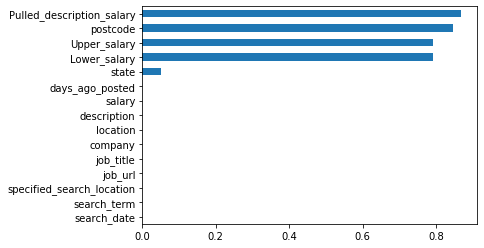

In [950]:
#18. Reviewing missing values. Most values are missing on the salary, which is somewhat expected
#Most postcodes are also missing, which is likely due to the fact that most city job postings do not include a postcode
#and therefore these would need to be dealt with in another way (e.g, AusPost API to lookup postcodes)
missing_values = pd.Series(df_search_clean.isnull().sum()/len(df_search_clean)).sort_values(ascending=True)
missing_values.plot(kind='barh')

In [951]:
#19. Here unique values in the data set are reviewed. 
#There are four target jobs
print('Job search criteria in data-set:',df_search_clean.search_term.unique())
print('--------')
#Based within Australia
print('Job search search criteria locations in data-set:',df_search_clean.specified_search_location.unique())
print('--------')
print('Total unique states/territories:', len(df_search_clean.state.unique()))
print('--------')
print('Total unique suburbs:', len(df_search_clean.location.unique()))
#As can be seen a wide range of suburbs (190) are represented in the data set.

Job search criteria in data-set: ['research+scientist' 'data+scientist' 'machine+learning+engineer'
 'data+analyst']
--------
Job search search criteria locations in data-set: ['Australia']
--------
Total unique states/territories: 9
--------
Total unique suburbs: 190


In [952]:
#20. Lets also review the job titles we have
df_search_clean["job_title"].value_counts()
#It appears that the fifth most common job title is 'This job has expired on Indeed', which appears to occur
#when a listing is usually over 30 days. Therefore, we will remove these rows from the data-set

#21. This removes the 'This job has expired on Indeed' that was identified as an issue in the data set above. 
expired_index = df_search_clean[df_search_clean['job_title'] == 'This job has expired on Indeed'].index
df_search_clean.drop(expired_index , inplace=True)

Data Scientist                               106
Data Analyst                                  63
Data Engineer                                 34
Business Analyst                              32
This job has expired on Indeed                31
                                            ... 
Principal Engineer - Flooding                  1
RESEARCH FELLOW IN LIFE HISTORY MODELLING      1
People & Culture Analyst                       1
Systems & Reporting Analyst                    1
Senior Agile Project Manager                   1
Name: job_title, Length: 1339, dtype: int64

Text(0, 0.5, 'Job Title')

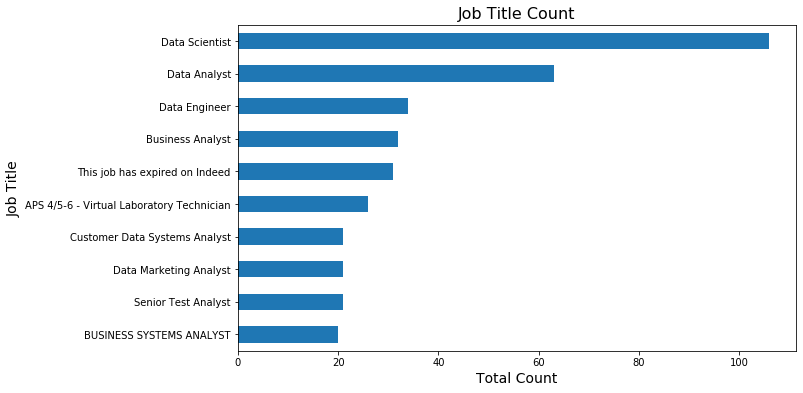

In [954]:
#22. Plot of top job title counts. As can be seen, Data Scientist, Data Analyst, and Data Engineer are amongst most common specific job
#titles. This though only includes specific job titles and does not capture job titles where "Data Scientist" may appear anywhere in the title.
df_search_clean["job_title"].value_counts().head(10).sort_values().plot(kind='barh', figsize=(10,6))
plt.title('Job Title Count', fontdict={'fontsize': 16})
plt.xlabel('Total Count', fontdict={'fontsize': 14})
plt.ylabel('Job Title', fontdict={'fontsize': 14})

#### Investigating Salary

As part of the instructions is that the minimise the liklihood that a client is incorrectly informed of a higher salary job than a lower salary position, it would make sense to make the target the lower salary band. Thus, lower salary is the main target for current purposes.

In [955]:
#23. Investigating the lower salary target
df_search_clean.Lower_salary.describe()

count       495.000000
mean      88779.159596
std       32635.727193
min       10000.000000
25%       67100.000000
50%       80000.000000
75%      100000.000000
max      240000.000000
Name: Lower_salary, dtype: float64

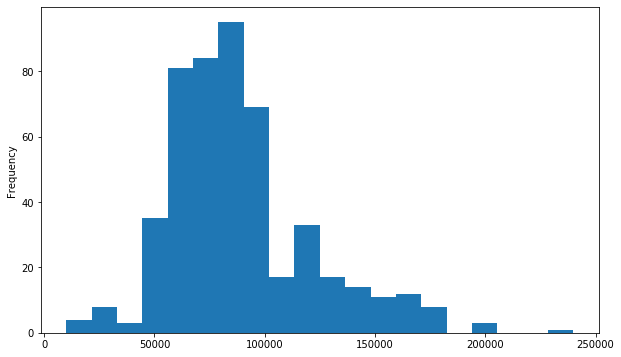

In [960]:
#24. Reviewing distribution of lower salary, which will be the target variable. 
df_search_clean.Lower_salary = df_search_clean.Lower_salary.fillna(np.nan)
df_search_clean.Lower_salary.plot(kind='hist', bins=20, figsize=(10,6))
#As can be seen, there is a postive distribution and so we should also probably consider a log-transformation of salary or truncating outliers
#There is also some salaries that do not appear to be appropriate from a yearly salary perspective. In Australia, the minimum year wage is 
#approx $38,521 ($740.80 a week * 52) see (https://www.fairwork.gov.au/how-we-will-help/templates-and-guides/fact-sheets/minimum-workplace-entitlements/minimum-wages))
#However, there are salaries that are clearly below this. 

In [961]:
#25. Inspecting the job titles of those under the minumum wage reveals that these job postings
#are more associated with scholarships and Cadetships. There are though other roles flagging
#up that do not make sense. For example, the Study Director - Immunoassay is unlikely to have a 
#true wage lower then the minimum wage. Also the E-Commerce Data Analyst and Business Analyst 
#needs closer inspection around the what wage are associated with these roles. 
df_search_clean[df_search_clean['Lower_salary'] < 38521].job_title

74      PhD studentship - Development of Barrier Encap...
98              Monash University - CSIRO PhD studentship
127            Indigenous Cadetships - Data61 Engineering
143       Indigenous Cadetships - Data61 Computer Science
153     Indigenous Cadetships - Data61 Mathematics & S...
242     PhD Top-Up Scholarships: Defence Science and T...
450            Indigenous Cadetships - Data61 Engineering
470       Indigenous Cadetships - Data61 Computer Science
489     Indigenous Cadetships - Data61 Mathematics & S...
653                          Study Director - Immunoassay
689     PhD Top-Up Scholarships: Defence Science and T...
1259    E-Commerce Data Analyst - Social Media Analyst...
2117                Business Analyst | Epping | Full Time
Name: job_title, dtype: object

In [962]:
#26. Further inspecting with the lower salary field shows that several of these
#have salaries that would be expected to be much higher (e.g. index 653 and 2117) as flagged above based on titles.
print(df_search_clean[df_search_clean['Lower_salary'] < 38521].Lower_salary)
#Therefore we will drop these rows from the data-set as they appear to be a problem with
#either the extraction or the salary information included in the job post and, thus, cannot be trusted.
df_search_clean.drop(2117, inplace=True) #<-- drops the Business Analyst | Epping | Full Time role
df_search_clean.drop(653, inplace=True) #<-- drops the Study Director - Immunoassay
#The other fields though appear appropriate for the nature of the job position (e.g. internship, cadetship, scholarships)

74      27872.0
98      27872.0
127     28800.0
143     28800.0
153     28800.0
242     10000.0
450     28800.0
470     28800.0
489     28800.0
653     10000.0
689     10000.0
1259    35000.0
2117    15900.0
Name: Lower_salary, dtype: float64


In [1016]:
#27. Reivestigating the salary target shows that dropping the two jobs above has increase the mean wage by around $300.
df_search_clean.Lower_salary.describe()

count       493.000000
mean      89086.782961
std       32340.622943
min       10000.000000
25%       67100.000000
50%       80000.000000
75%      100000.000000
max      240000.000000
Name: Lower_salary, dtype: float64

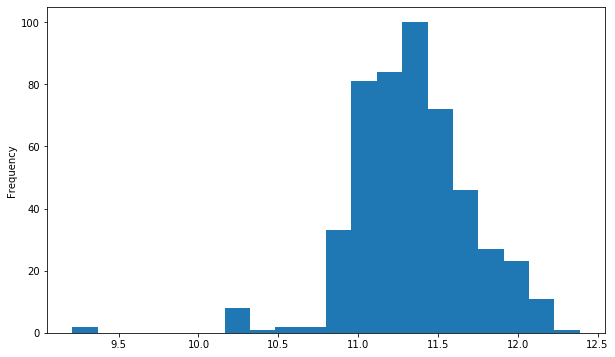

In [1018]:
#Investigating the log transofmration of lower salary. This appears to be more suitable as a target.
#Although, there is an outler at the bottom range. 
df_search_clean.Lower_salary.agg(np.log).plot(kind='hist', bins=20, figsize=(10,6))

In [965]:
#28. As we have multiple job types, it is important to create a flag that will identify the type of job listing.
#Here I have created a range of new flag variables based on the nature of the position (e.g permanent, full time, casual etc.)
#First just ensure thats the description column is a string variable
df_search_clean['description'] = df_search_clean['description'].astype('str')

#Create 9 new flag variables and populate them with 0 indicating currently no presence
#The first set speaks to the nature of the role
df_search_clean["Casual_flag"] = 0
df_search_clean["Part_time_flag"] = 0
df_search_clean["Full_time_flag"] = 0

#The second set speaks to the length of the role
df_search_clean["Temporary_flag"] = 0
df_search_clean["Permanant_flag"] = 0
df_search_clean["Contract_flag"] = 0

#The final set attempts to identify those positions that are not 'standard' jobs
df_search_clean["Internship_flag"] = 0
df_search_clean["Volunteer_flag"] = 0
# df_search_clean["Apprenticeship_flag"] = 0 REMOVED AS ONLY ONE IN THE DATA SET FOUND
df_search_clean["Cadetship_flag"] = 0
df_search_clean["Scholarship_flag"] = 0

#This identifies roles that contain reference to part time in either the description or salary fields and then updates flag to 1 if found
part_time_mask = df_search_clean[(df_search_clean.description.str.contains(r'(p|P)art(\s|-)(t|T)ime')) | (df_search_clean.salary.str.contains(r'(p|P)art(\s|-)(t|T)ime'))].Part_time_flag.apply(lambda x: 1)
df_search_clean['Part_time_flag'].loc[part_time_mask.index] = part_time_mask

#This identifies roles that contain reference to full time in either the description or salary fields and then updates flag to 1 if found
full_time_mask = df_search_clean[(df_search_clean.description.str.contains(r'(f|F)ull(\s|-)(t|T)ime')) | (df_search_clean.salary.str.contains(r'(f|F)ull(\s|-)(t|T)ime'))].Full_time_flag.apply(lambda x: 1)
df_search_clean['Full_time_flag'].loc[full_time_mask.index] = full_time_mask

#This identifies roles that contain reference to permanant in either the description or salary fields and then updates flag to 1 if found
permanant_mask = df_search_clean[(df_search_clean.description.str.contains(r'(p|P)ermanent')) | (df_search_clean.salary.str.contains(r'(p|P)ermanent'))].Permanant_flag.apply(lambda x: 1)
df_search_clean['Permanant_flag'].loc[permanant_mask.index] = permanant_mask

#This identifies roles that contain reference to contract in either the description or salary fields and then updates flag to 1 if found
contract_mask = df_search_clean[(df_search_clean.description.str.contains(r'(c|C)ontract')) | (df_search_clean.salary.str.contains(r'(c|C)ontract'))].Contract_flag.apply(lambda x: 1)
df_search_clean['Contract_flag'].loc[contract_mask.index] = contract_mask

#This identifies roles that contain reference to internship in either the description or salary fields and then updates flag to 1 if found
internship_mask = df_search_clean[(df_search_clean.description.str.contains(r'(i|I)nternship')) | (df_search_clean.salary.str.contains(r'(i|I)nternship'))].Internship_flag.apply(lambda x: 1)
df_search_clean['Internship_flag'].loc[internship_mask.index] = internship_mask

#This identifies roles that contain reference to volunteer in either the description or salary fields and then updates flag to 1 if found
volunteer_mask = df_search_clean[(df_search_clean.description.str.contains(r'(v|V)olunteer')) | (df_search_clean.salary.str.contains(r'(v|V)olunteer'))].Volunteer_flag.apply(lambda x: 1)
df_search_clean['Volunteer_flag'].loc[volunteer_mask.index] = volunteer_mask

#This identifies roles that contain reference to casual in either the description or salary fields and then updates flag to 1 if found
casual_mask = df_search_clean[(df_search_clean.description.str.contains(r'(c|C)asual')) | (df_search_clean.salary.str.contains(r'(c|C)asual'))].Casual_flag.apply(lambda x: 1)
df_search_clean['Casual_flag'].loc[casual_mask.index] = casual_mask

#This identifies roles that contain reference to temporary in either the description or salary fields and then updates flag to 1 if found
temporary_mask = df_search_clean[(df_search_clean.description.str.contains(r'(t|T)emporary')) | (df_search_clean.salary.str.contains(r'(t|T)emporary'))].Temporary_flag.apply(lambda x: 1)
df_search_clean['Temporary_flag'].loc[temporary_mask.index] = temporary_mask

# #This identifies roles that contain reference to apprenticeship in either the description or salary fields and then updates flag to 1 if found
# apprenticeship_mask = df_search_clean[(df_search_clean.description.str.contains(r'(a|A)pprenticeship')) | (df_search_clean.salary.str.contains(r'(a|A)pprenticeship'))].Apprenticeship_flag.apply(lambda x: 1)
# df_search_clean['Apprenticeship_flag'].loc[apprenticeship_mask.index] = apprenticeship_mask

#This identifies roles that contain reference to cadetship in either the description or salary fields and then updates flag to 1 if found
cadetship_mask = df_search_clean[(df_search_clean.description.str.contains(r'(c|C)adetship')) | (df_search_clean.salary.str.contains(r'(c|C)adetship'))].Cadetship_flag.apply(lambda x: 1)
df_search_clean['Cadetship_flag'].loc[cadetship_mask.index] = cadetship_mask

#This identifies roles that contain reference to Scholarship in either the description or salary fields and then updates flag to 1 if found
scholarship_mask = df_search_clean[(df_search_clean.description.str.contains(r'(s|S)cholarship')) | (df_search_clean.salary.str.contains(r'(s|S)cholarship'))].Scholarship_flag.apply(lambda x: 1)
df_search_clean['Scholarship_flag'].loc[scholarship_mask.index] = scholarship_mask

C:\Users\matth\Anaconda3\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Text(0, 0.5, 'Job Flag Type')

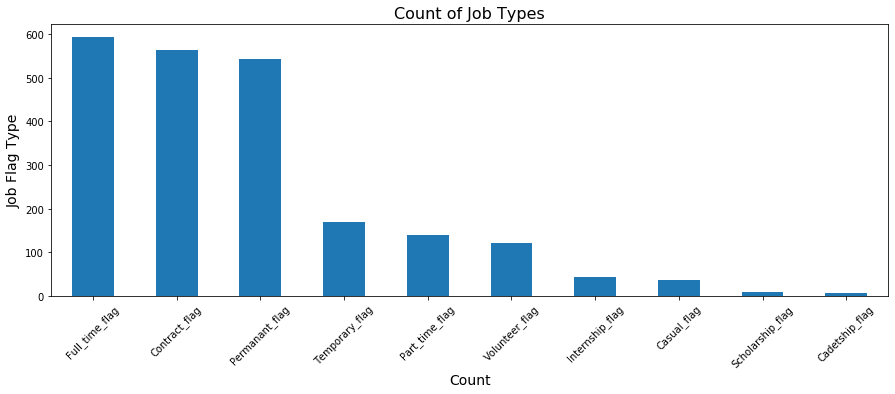

In [966]:
#29. It is important to see how many jobs have been classified by this method to get an understanding of the types of jobs in the data set. 
df_search_clean[['Casual_flag',
                'Part_time_flag',
                'Full_time_flag',
                'Temporary_flag',
                'Permanant_flag',
                'Contract_flag',
                'Internship_flag',
                'Volunteer_flag',
#                 'Apprenticeship_flag',
                'Cadetship_flag',
                'Scholarship_flag']].sum().sort_values(ascending=False).plot.bar(figsize=(15,5), rot=45)
ax = plt.gca()
plt.plot(figsize=(10,10))
plt.title('Count of Job Types', fontdict={'fontsize': 16})
plt.xlabel('Count', fontdict={'fontsize': 14})
plt.ylabel('Job Flag Type', fontdict={'fontsize': 14})
#As expected, most jobs are full time and permanent with lower numbers of temp and part time jobs.

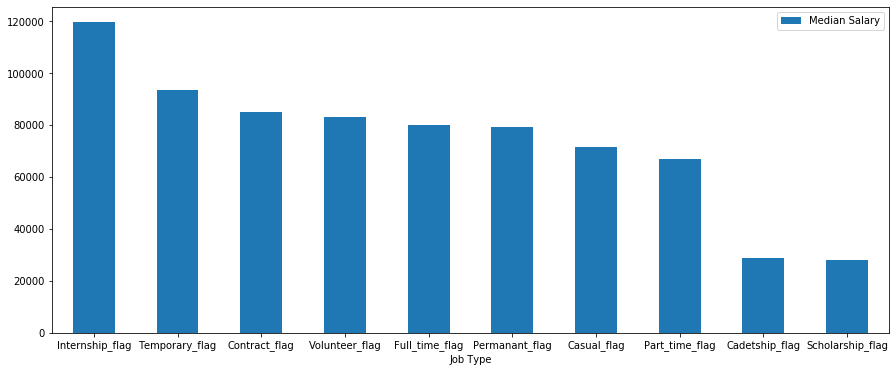

In [977]:
#30. Let have a look at the salaries associated with each of these job/listing types. 
list_job_dollar = ['Casual_flag',
                'Part_time_flag',
                'Full_time_flag',
                'Temporary_flag',
                'Permanant_flag',
                'Contract_flag',
                'Internship_flag',
                'Volunteer_flag',
                'Cadetship_flag',
                'Scholarship_flag']

list_salaries = []

for x in list_job_dollar:
    list_salaries.append(df_search_clean.groupby(by=x)['Lower_salary'].agg(np.median)[1]) 

type_salary_median = pd.DataFrame(zip(list_job_dollar,list_salaries))
type_salary_median.rename(columns={0:'Job Type', 1:'Median Salary'}, inplace=True)
type_salary_median.sort_values(by='Median Salary', ascending=False).plot(kind='bar',x='Job Type', y='Median Salary', figsize=(15,6), rot=0)
#It is clear that Intership is probelmatic here as this should not be the highest valued job type. 
#Investigating the rows containing Internship revealed that a Lecturer position had been flagged with reference to 
#overseeing internships and thus had been misclassified as an internship role. Other permananent roles had also been
#misclassified. In addition, the volunter flag appears to be capturing inappropriate job positions as shown by the 
#high salary. Therefore, these labels are dropped from future analyses.  
df_search_clean.drop(['Volunteer_flag','Internship_flag'], axis=1, inplace=True)

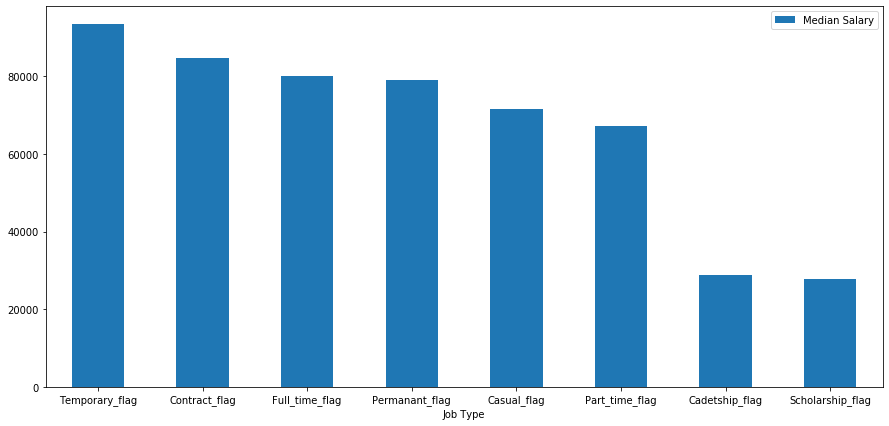

In [1114]:
#31. Rerunning the analysis with theinternship and volunter flags dropped make more intuitive sense. Temp positions tend 
#to have higher salaries as part compensation for the temp nature of the role and thus we would expect a higher annual
#(calculated) from these roles. Likewise, contracts, tend #to have also higher salaries for similar reasons. At the 
#other end of the scale, we would except Cadetships and Scholarships to be at the lower end, where they are. 
list_job_dollar = ['Casual_flag',
                'Part_time_flag',
                'Full_time_flag',
                'Temporary_flag',
                'Permanant_flag',
                'Contract_flag',
                'Cadetship_flag',
                'Scholarship_flag']

list_salaries = []

for x in list_job_dollar:
    list_salaries.append(df_search_clean.groupby(by=x)['Lower_salary'].agg(np.median)[1]) 

type_salary_median = pd.DataFrame(zip(list_job_dollar,list_salaries))
type_salary_median.rename(columns={0:'Job Type', 1:'Median Salary'}, inplace=True)
type_salary_median.sort_values(by='Median Salary', ascending=False).plot(kind='bar',x='Job Type', y='Median Salary', figsize=(15,7), rot=0)

Text(0, 0.5, 'Search Criteria')

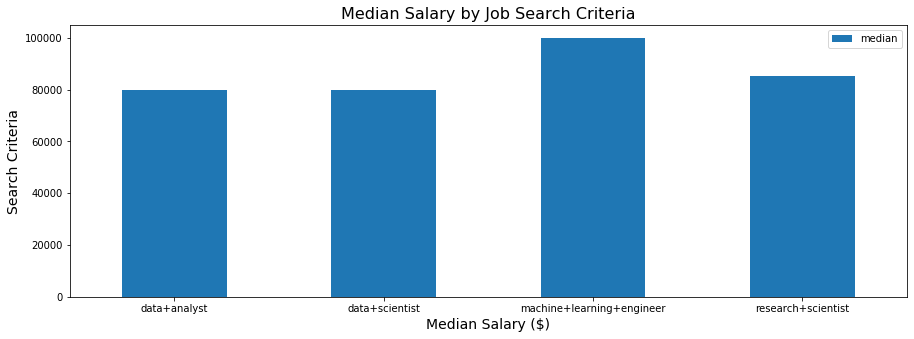

In [974]:
#32. Lets now investigate salary by Indeed.com search criteria
df_search_clean.groupby(by='search_term').Lower_salary.agg([np.median]).plot(kind='bar', figsize=(15,5), rot=0)
plt.title('Median Salary by Job Search Criteria', fontdict={'fontsize': 16})
plt.xlabel('Median Salary ($)', fontdict={'fontsize': 14})
plt.ylabel('Search Criteria', fontdict={'fontsize': 14})

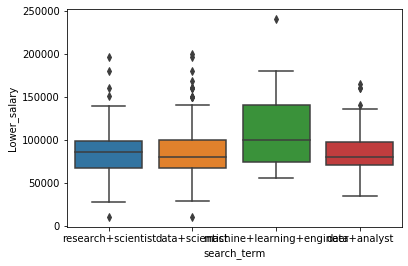

In [144]:
# 33. Similarily, a box plot shows machine learning engineers having the higest mean wage. However, this
#appears to be driven by a particularly high wage that is classified as on outlier. Reviewing this outlier though
#suggests a genuine position that probably should be kept in as represents a real-world job that would be appropriate
#to include in modelling. 
ax=sns.boxplot(x='search_term',y='Lower_salary',data=df_search_clean)

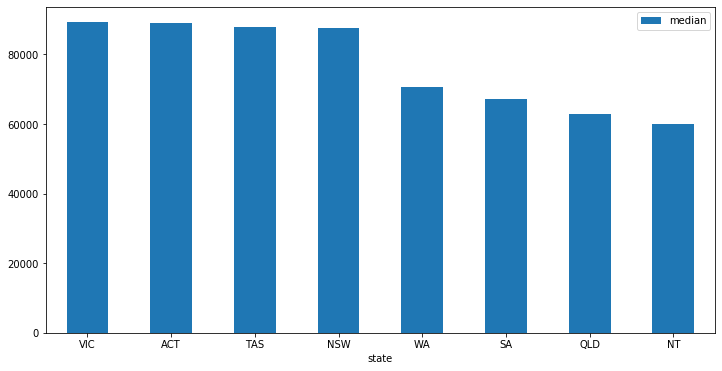

In [1011]:
#34. InvestigaingInvestigating median lower salary by Australian state/territory reveals that VIC, ACT, TAS, and NSW have higher median salaries
#vs. other states/territories. This aligns to other known information regarding salaries 
#(e.g. HAYS salary guide https://www.hays.com.au/salary-guide/index.htm )
df_search_clean.groupby(by='state').Lower_salary.agg([np.median]).sort_values(by='median', ascending=False).plot(kind='bar', figsize=(12,6), rot=0)

#### Creating Salary Target Bands
While it is possible to create a salary band based on a median split or in thirds at the 33.33 and 66.66 percentile rank, as the data represents 4 different search criteria, it seem less useful from the persepctive of discussing salary. For example, speaking in terms of a high or low salary would mean high or low in respect to the median of four other job groups that were searched for (i.e. data scientist, data analyst, machine learning engineer, and research scientist) rather than in terms of what salary one would expect. From the perspective of the task in hand, therefore, it would make more sense to either model based on:

* **a continious target (i.e. regression problem)**; or
* **by a set of salary bins that do not necessarily indicate "high" or "low" but simply are a target salary class (classification problem)** 

For this reason, I will develop models for both types of targets. While the target for a linear regression is already avaliable, I will now create a number of salary bins for the classification version of the problem. In this case, I have decided to have four salary groups:

 1. Less than \$65,000 
 
 2. \\$65,001-\$80,000 
 
 3. \\$80,001-\$110,000
 
 4. More than \$110,000**

In [1012]:
#35. Creating an alternative target salary for classification, with four salary targets classes
salary_cat = ["Less than \$65,000", "\$65,001-\$80,000", "\$80,001-\$110,000", 'More than \$110,000']
df_search_clean['salary_bin'] = pd.cut(x=df_search_clean['Lower_salary'],bins=[0, 65000, 80000, 110000,2400001], labels=salary_cat, right=False)

Text(0, 0.5, 'Job Title')

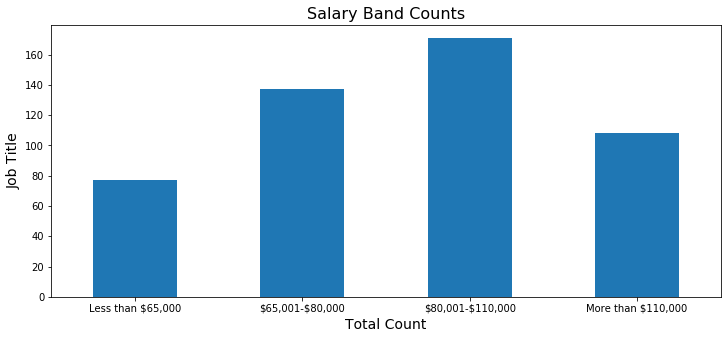

In [1015]:
#36. Investigating sizes of salary target bands. As can be seen, most salaryies fall in the $80-001-110,000 band, which is to be expected.
df_search_clean.groupby(by='salary_bin').size().plot(kind='bar', figsize=(12,5), rot=0)
plt.title('Salary Band Counts', fontdict={'fontsize': 16})
plt.xlabel('Total Count', fontdict={'fontsize': 14})
plt.ylabel('Job Title', fontdict={'fontsize': 14})

## Text Processing

<left><img src="https://miro.medium.com/max/797/1*OSkd33sQ_rtAoJavKaoHNw.jpeg" width="800" height="100"></left>


We are now in a position to model features of jobs that predict salary (Question 1). For this, we first need to process the job descriptions to extract and create new features and use these as part of modelling. For this, I have used a 'bag of words' approach. 

#### Bag of Words
The bag-of-words model is simple. Specifically, we "tokenise" words in each job descriptions and then calculate the frequency of each particular 'token'. A single token (i.e. a word) is called a 'gram, while two is called a bi-gram, three a tri-gram and so forth.

Vectorization is about converting text into numbers that can be used for machine learning. Different ways to convert text into vectors are:
* **CountVectiorizer**: works on Terms Frequency and is essentially a simple count of the each time a token occurs in a job (or document in NLP terminology).
* **TF-IDF Vectorizer**: TF-IDF stands for term frequency-inverse document frequency and is designed in a way that provides a measure for how important a word is in a document by taking into consideration the number of word occurs in a document vs. accross all documents. It assumes that a token is more important when occuring in a specific document while occuring less frequently across all documents.

#### Tokenization

In [152]:
#1. Dropping unneccessary columns for tokenisation and modelling and creating a testing df to work on. 
df_testing = df_search_clean.drop(columns=['job_url','postcode','search_date','days_ago_posted'])
#2. And then dropping rows where salary has null values
df_testing = df_testing.dropna(subset=['Lower_salary'])
#Checking shape of final testing data set. Have 492 rows with salary information and 20 initial features, which makes sense
print(df_testing.shape)

(492, 20)


In [237]:
# #Investigating extreme upper and lower ranges for Lower_salary in terms of outlier ranges against IQR*3 criteria
# salary_extreme_extreme_upper_range = ((np.quantile([df_testing['Lower_salary']],0.75)\
#                           - np.quantile([df_testing['Lower_salary']],0.25))*3)\
#                             + np.quantile([df_testing['Lower_salary']],0.75)
# salary_extreme_extreme_lower_range = (np.quantile([df_testing['Lower_salary']],0.25)\
#                        -(np.quantile([df_testing['Lower_salary']],0.75)\
#                          - np.quantile([df_testing['Lower_salary']],0.25))*3)

# print("Upper:",salary_extreme_extreme_upper_range)
# print("Lower:",salary_extreme_extreme_lower_range)

In [154]:
#3. Creating 'bag of words' for Vectorisation and converting to lower case on the assumption that case is not an important feature for current purposes. 
df_testing['bag_of_words'] = df_testing[['search_term','job_title', 'company', 'description','location']].stack().groupby(level=0).apply(','.join).str.lower()
#3.1 To ensure that target is not also appearing in feature space, removing all salary strings to reduce liklihood of independence assumption being violated.
df_testing['bag_of_words'] = df_testing.bag_of_words.str.replace('\$(\d\d(,|.|\s)\d\d\d+)',' ').str.replace('\$\d\d\d',' ')

In [1029]:
#4. Create list of stop words to pull out irrelevant words and punctuation. These strop words
#are based on the standard lists provided in the NLTK and sklearn packages, which have been combined with bespoke
#stop words for this project. 
standard_stop_words = list(list(ENGLISH_STOP_WORDS) + list(punctuation))

#4.1 Adding specific words relevant to existing custom_stop_words based on 
#iterative manual analysis of outputs and item importance
bespoke_stop_words = ['click', 
                      'apply',
                      'com',
                      'www',
                      'love',
                      'super',
                      'bonus',
                      'existing',
                      'keen',
                      'works',
                      'use',
                      '00',
                      '18',
                      'data',
                      'truly']

#4.2 Combining lists into final stop_word list to use
final_stop_words = standard_stop_words + bespoke_stop_words

In [1030]:
#5. Creating X and y variables
#X is based on the 'bag of words' created above. 
X = df_testing['bag_of_words'].values
#As the target is going to be the log of lower salary, we assign the log transformation of lower salary to y.
y = df_testing.Lower_salary.agg(np.log)
#5.1 And then creating a training set and hold out set for testing.
#This has been done as I was concerned that using cross_validation may be problematic
#on this data set due to number of features being more than the number of rows, which would be further
#impacted by the way in which cross-fold works. Potentially training could have only been on around 50-100 documents
#per fold depending on the CV selected. Consequrntly, for current purposes, testing was done on a hold out set as default value of 0.25
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [1031]:
#6. Intialise a TfidVectorizer
vect = TfidfVectorizer(stop_words=final_stop_words,
                       min_df=10,
                       max_df=70)

#6.1 And fit the TfidVectoriszer to the training and testing data. 
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [158]:
#6.1. Implementment a CountVectorizer
vect_count = CountVectorizer(stop_words=final_stop_words,
                       min_df=10,
                       max_df=70)

X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

#### Modelling: Linear Regression
In the first model, I will first fit a linear regression model to predict actual lower salary using feature extracted from the TfidVectorizer.

In [1032]:
#7. Specify model for analysis
lr = LinearRegression()

#7.1 Create an initial pipeline with Vectoriser, Normaliser, and linear regression
#Normaliser will allow for direct comparisons between important features.  
pipe = make_pipeline(vect,Normalizer(),lr)

In [160]:
#8. Getting keys associated with the pipeline for use in gridsearch
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidfvectorizer', 'normalizer', 'linearregression', 'tfidfvectorizer__analyzer', 'tfidfvectorizer__binary', 'tfidfvectorizer__decode_error', 'tfidfvectorizer__dtype', 'tfidfvectorizer__encoding', 'tfidfvectorizer__input', 'tfidfvectorizer__lowercase', 'tfidfvectorizer__max_df', 'tfidfvectorizer__max_features', 'tfidfvectorizer__min_df', 'tfidfvectorizer__ngram_range', 'tfidfvectorizer__norm', 'tfidfvectorizer__preprocessor', 'tfidfvectorizer__smooth_idf', 'tfidfvectorizer__stop_words', 'tfidfvectorizer__strip_accents', 'tfidfvectorizer__sublinear_tf', 'tfidfvectorizer__token_pattern', 'tfidfvectorizer__tokenizer', 'tfidfvectorizer__use_idf', 'tfidfvectorizer__vocabulary', 'normalizer__copy', 'normalizer__norm', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [1033]:
#9. It is important to identify an optimal hyperparameters to specify in the tokenisation.
#For this, I will use GridSearchCV to identify the best paramters to pass to the pipeline
params_lr_test = {'tfidfvectorizer__ngram_range': [(1, 3), (1, 4), (1,5)],\
                  'tfidfvectorizer__min_df': [8, 10],\
                  'tfidfvectorizer__max_df': [150,170],\
                  'tfidfvectorizer__max_features': [3000,3200]}

#9.1 Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe = GridSearchCV(pipe,params_lr_test,verbose=2)

#9.2. Fit the grid_pipe to the training data
grid_pipe.fit(X_train,y_train)

#9.3 And print out the best paramters to the screen
print("Best paramters are: ", grid_pipe.best_params_)

# This therefore, specifies a range of n_grams to iterate over as part of gridsearch
# start_range = range(1,5)
# end_range = range(1,5)

#8.1 This creates a list of ngram parameters to iterate over that will be passed into the pipeline
# params_lr = {k:[(i,j) for i in start_range for j in end_range if j > i]\
#              for  k in pipe.get_params().keys() if 'ngram' in k\}

# grid_pipe = GridSearchCV(pipe,params_lr,verbose=2)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3), total=   0.7s
[CV] tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3), total=   0.7s
[CV] tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3) 
[CV]  tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3), total=   0.7s
[CV] tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3) 
[CV]  tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3), total=   0.7s
[CV] tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3) 
[CV]  tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3), total=   0.7s
[C

[CV]  tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3), total=   0.7s
[CV] tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3) 
[CV]  tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3), total=   0.7s
[CV] tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3) 
[CV]  tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3), total=   0.7s
[CV] tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3) 
[CV]  tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3), total=   0.7s
[C

[CV]  tfidfvectorizer__max_df=150, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=10, tfidfvectorizer__ngram_range=(1, 5), total=   1.3s
[CV] tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3) 
[CV]  tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3), total=   0.7s
[CV] tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3) 
[CV]  tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3), total=   0.7s
[CV] tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3) 
[CV]  tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3), total=   0.7s
[

[CV]  tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=10, tfidfvectorizer__ngram_range=(1, 5), total=   1.2s
[CV] tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=10, tfidfvectorizer__ngram_range=(1, 5) 
[CV]  tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3000, tfidfvectorizer__min_df=10, tfidfvectorizer__ngram_range=(1, 5), total=   1.2s
[CV] tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3) 
[CV]  tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3), total=   0.6s
[CV] tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3) 
[CV]  tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=8, tfidfvectorizer__ngram_range=(1, 3), total=   0.7s

[CV]  tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=10, tfidfvectorizer__ngram_range=(1, 5), total=   1.2s
[CV] tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=10, tfidfvectorizer__ngram_range=(1, 5) 
[CV]  tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=10, tfidfvectorizer__ngram_range=(1, 5), total=   1.2s
[CV] tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=10, tfidfvectorizer__ngram_range=(1, 5) 
[CV]  tfidfvectorizer__max_df=170, tfidfvectorizer__max_features=3200, tfidfvectorizer__min_df=10, tfidfvectorizer__ngram_range=(1, 5), total=   1.1s


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.9min finished


Best paramters are:  {'tfidfvectorizer__max_df': 150, 'tfidfvectorizer__max_features': 3200, 'tfidfvectorizer__min_df': 8, 'tfidfvectorizer__ngram_range': (1, 3)}


Text(0, 0.5, 'Predicted (Lower)  Log Salary')

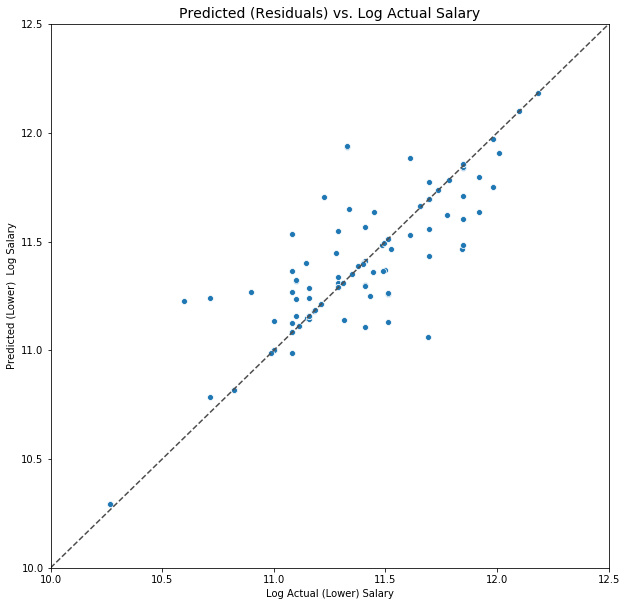

In [1037]:
#10. Create a residuals plot for inspecting errors. 
y_hat = grid_pipe.predict(X_test)
ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(y_test, y_hat)

ax = plt.gca()

#This sets the axis to the same 
plt.ylim(10,12.5 )
plt.xlim(10,12.5 )

ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.title('Predicted (Residuals) vs. Log Actual Salary', fontdict={'fontsize': 14})
plt.xlabel('Log Actual (Lower) Salary')
plt.ylabel('Predicted (Lower)  Log Salary')
#In general, the spread of the residuals is randomly falling around the diagnoal. 

In [1038]:
#11. It is important to see which features are more important at predicting salary to see if they make sense in the model. 
from IPython.display import display
print("R2 on test data is: ", grid_pipe.score(X_test,y_test))
display(eli5.show_weights(grid_pipe.best_estimator_[-1],feature_names=grid_pipe.best_estimator_[0].get_feature_names()))

R2 on test data is:  0.7091314060977421


In [1036]:
#12. This prints out the most important features to a pandas dataframe for investigation
lr_coefficient_dataframe = pd.DataFrame({'Feature':grid_pipe.best_estimator_[0].get_feature_names(),
                                      'Coefficient':grid_pipe.best_estimator_[-1].coef_,                                   
                                      'Coefficient Absolute': abs(grid_pipe.best_estimator_[-1].coef_)})
lr_coefficient_dataframe.sort_values(by='Coefficient Absolute', ascending=False).head(30)

,Feature,Coefficient,Coefficient Absolute
1727,manager,2.355921,2.355921
609,contract,2.195616,2.195616
698,day,1.925486,1.925486
2170,product,0.897121,0.897121
1270,graduate,-0.859373,0.859373
1023,entry,-0.763084,0.763084
2020,performance,-0.741615,0.741615
1275,group,-0.738985,0.738985
106,advanced,-0.643887,0.643887
827,device,-0.640355,0.640355


Text(0, 0.5, 'Feature')

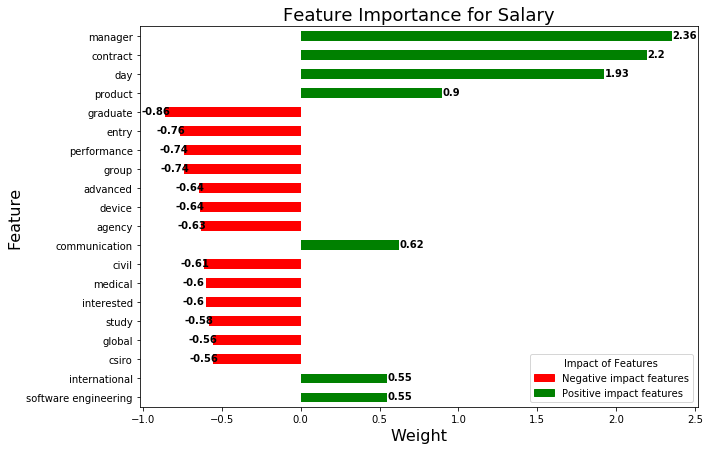

In [1078]:
#13. Plotting feature importance. 
import matplotlib.patches as mpatches

top_20_features_lr = lr_coefficient_dataframe.sort_values(by='Coefficient Absolute', ascending=False).head(20)
top_20_features_lr = top_20_features_lr.sort_values(by='Coefficient Absolute', ascending=True)
top_20_features_lr['colour']=top_20_features_lr['Coefficient'].apply(lambda x : 'green' if x>0 else 'red')

#top_20_features_lr = lr_coefficient_dataframe.sort_values(by='Coefficient Absolute', ascending=False).head(20)
# lr_coefficient_dataframe = lr_coefficient_dataframe_sort.sort_values('Coefficient Absolute',ascending=True)
top_20_features_lr.plot(x='Feature',
                                        y='Coefficient',
                                        kind='barh',
                                        figsize=(10,7),color=top_20_features_lr['colour'])
ax = plt.gca()

# #This sets the axis to the same 
# plt.xlim(-3000, 8000)
# plt.axvline(x=0)
# plt.grid(b=False)

#Create a legend labels for colour coded bars
negative_features = mpatches.Patch(color='red', label='Negative impact features')
positive_features= mpatches.Patch(color='green', label='Positive impact features')

ax.legend(handles=[negative_features,positive_features],title='Impact of Features',loc='lower right')

for i, v in enumerate(top_20_features_lr['Coefficient']):
    if v>=0:
        ax.text(v, i-0.1, str(round(v,ndigits=2)), color='black', fontweight='bold')
    if v<0:
        ax.text(v-0.15, i-0.1, str(round(v,ndigits=2)), color='black', fontweight='bold')

plt.title('Feature Importance for Salary', fontdict={'fontsize': 18})
plt.xlabel('Weight', fontdict={'fontsize': 16})
plt.ylabel('Feature', fontdict={'fontsize': 16})

##### Takeaways
* Unsuprisingly, the appearance of 'manager' has the strongest upwards impact on salary aligned with their increased responsibility and experience in these roles.
* The apperance of 'contract' and 'day' is interesting and their upward influence on salary likely to be due to increased compensation for these types of roles in terms of other benefits not avaliable to permanent staff (e.g. holiday time; employment safety; etc). 
* The appearance of 'graduate' or 'entry' has the strongest downward influences on salary, which is to be expected given these roles will require less experience and skills and thus are of less value to a company.
* Communication is another reasonable feature to emerge and probably is related to the fact that good communication facilitates improved performance. 
* The feature of 'medical, study, csiro' all seem to be related to more research based roles (e.g. research scientist), and these have a downwards influence on salary levels. 
* Other features are less clear on their role (e.g. 'performance' - negative; 'group' - negative) would need to be further investgiated by reviewing roles that contain these features. 

#### Classification Models

I will now investigate predicting salary using Classification Models to predict the four salary bins created earlier.

In [164]:
#1. When assessing accruracy with classification models, we first need to identify the baseline accuracy.
#In this case, the majority salary class is $70,001-$90,000, which is 30.14% and is the baseline accuracy to achieve with any modeling
df_testing.salary_bin.value_counts(normalize=True)#.sort_values(ascending=False)

$80,001-$110,000      0.345528
$65,001-$80,000       0.278455
More than $110,000    0.219512
Less than $65,000     0.156504
Name: salary_bin, dtype: float64

In [167]:
#2. I will now make some new variables for use in this. 
#Creating classification X and y variables
X_class = df_testing['bag_of_words'].values
y_class = df_testing.salary_bin
#And then creating a training set and hold out set for testing
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X,y_class, random_state=42)

X_train_dtm_class = vect.fit_transform(X_train)
X_test_dtm_class = vect.transform(X_test)

##### Random Forests

In [166]:
#3. Setting up a 
rf = RandomForestClassifier(random_state=42)
pipe_rf = make_pipeline(vect,Normalizer(),rf)

In [168]:
pipe_rf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidfvectorizer', 'normalizer', 'randomforestclassifier', 'tfidfvectorizer__analyzer', 'tfidfvectorizer__binary', 'tfidfvectorizer__decode_error', 'tfidfvectorizer__dtype', 'tfidfvectorizer__encoding', 'tfidfvectorizer__input', 'tfidfvectorizer__lowercase', 'tfidfvectorizer__max_df', 'tfidfvectorizer__max_features', 'tfidfvectorizer__min_df', 'tfidfvectorizer__ngram_range', 'tfidfvectorizer__norm', 'tfidfvectorizer__preprocessor', 'tfidfvectorizer__smooth_idf', 'tfidfvectorizer__stop_words', 'tfidfvectorizer__strip_accents', 'tfidfvectorizer__sublinear_tf', 'tfidfvectorizer__token_pattern', 'tfidfvectorizer__tokenizer', 'tfidfvectorizer__use_idf', 'tfidfvectorizer__vocabulary', 'normalizer__copy', 'normalizer__norm', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'ra

In [169]:
#It would be good to identify an optimal hyperparameters to specify in the tokenisation.
#For this, I will use GridSearchCV to identify the best paramters to pass to the pipeline
params_rf_test = {'tfidfvectorizer__ngram_range': [(1, 4), (1,5)],\
                  'tfidfvectorizer__min_df': [12],\
                  'tfidfvectorizer__max_df': [120],\
                  'tfidfvectorizer__max_features': [2500],\
                  'randomforestclassifier__max_depth':[40,50,70],\
                  'randomforestclassifier__criterion': ['gini', 'entropy'],\
                  'randomforestclassifier__max_features': [10,15,20]}

# Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_rf = GridSearchCV(pipe_rf,params_rf_test,verbose=2)

#8.2. Fit the grid_pipe to the training data
grid_pipe_rf.fit(X_train_class,y_train_class)

#8.3 And print out the best paramters to the screen
prediction_class_rf = grid_pipe_rf.predict(X_test_class)

print("Best paramters are: ", grid_pipe_rf.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   1.0s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   1.0s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4) 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   0.9s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__mi

[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=15, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5), total=   1.2s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=15, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5) 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=15, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5), total=   1.2s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=15, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__mi

[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=50, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   1.0s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=50, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4) 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=50, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   1.0s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=50, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__mi

[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=50, randomforestclassifier__max_features=15, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5), total=   1.1s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=50, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4) 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=50, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   0.9s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=50, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__mi

[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=70, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5), total=   1.1s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=70, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5) 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=70, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5), total=   1.1s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=70, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__mi

[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=70, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   0.9s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=70, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4) 
[CV]  randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=70, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   0.9s
[CV] randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=70, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__mi

[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5), total=   1.2s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5) 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5), total=   1.3s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfve

[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   0.9s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4) 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   0.9s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfve

[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=50, randomforestclassifier__max_features=10, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5), total=   1.3s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=50, randomforestclassifier__max_features=15, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4) 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=50, randomforestclassifier__max_features=15, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   1.0s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=50, randomforestclassifier__max_features=15, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfve

[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=50, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5), total=   1.3s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=50, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5) 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=50, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5), total=   1.4s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=50, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfve

[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=70, randomforestclassifier__max_features=15, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   1.0s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=70, randomforestclassifier__max_features=15, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4) 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=70, randomforestclassifier__max_features=15, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   0.9s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=70, randomforestclassifier__max_features=15, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfve

[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=70, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5), total=   1.2s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=70, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5) 
[CV]  randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=70, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5), total=   1.3s
[CV] randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=70, randomforestclassifier__max_features=20, tfidfvectorizer__max_df=120, tfidfvectorizer__max_features=2500, tfidfve

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  3.3min finished


Best paramters are:  {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 40, 'randomforestclassifier__max_features': 20, 'tfidfvectorizer__max_df': 120, 'tfidfvectorizer__max_features': 2500, 'tfidfvectorizer__min_df': 12, 'tfidfvectorizer__ngram_range': (1, 4)}


In [170]:
#The ouput of the Random Forests Classification Model
print("RANDOM FORESTS CLASSIFICATION MODEL")
print("---------------------------")
print('Holdout set size', len(prediction_class_rf))
print("Best paramters are: ", grid_pipe_rf.best_params_)
print("Accuracy Score:",grid_pipe_rf.score(X_test_class, y_test_class))
print("\nClassification report\n",classification_report(y_test_class, prediction_class_rf))
print("\nConfusion Matrix\n",confusion_matrix(y_test_class, prediction_class_rf))

RANDOM FORESTS REGRESSION MODEL
---------------------------
Holdout set size 123
Best paramters are:  {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 40, 'randomforestclassifier__max_features': 20, 'tfidfvectorizer__max_df': 120, 'tfidfvectorizer__max_features': 2500, 'tfidfvectorizer__min_df': 12, 'tfidfvectorizer__ngram_range': (1, 4)}
Accuracy Score: 0.7642276422764228

Classification report
                     precision    recall  f1-score   support

   $65,001-$80,000       0.93      0.67      0.78        39
  $80,001-$110,000       0.58      0.90      0.71        39
 Less than $65,000       1.00      0.81      0.90        16
More than $110,000       0.91      0.69      0.78        29

          accuracy                           0.76       123
         macro avg       0.86      0.77      0.79       123
      weighted avg       0.82      0.76      0.77       123


Confusion Matrix
 [[26 13  0  0]
 [ 2 35  0  2]
 [ 0  3 13  0]
 [ 0  9  0 20]]


In [1101]:
#Investigate the most important classification features from the random forest classification model.
rf_coefficient_dataframe =pd.DataFrame(list(zip(grid_pipe.best_estimator_[0].get_feature_names(),
                                                grid_pipe_rf.best_estimator_[-1].feature_importances_)))
rf_coefficient_dataframe.rename(columns={0:'Feature',1:'rf_Importance'}, inplace=True)
rf_coefficient_dataframe.sort_values(by='rf_Importance',ascending=False).head(30)
#It is interesting to see that the features seen as most important for classification are not similar to those extracted
#from the linear regression demonstrating the fundamentally different approaches the two methods take. Indeed, many of these
#features are not immediatly clear as to their wider relevance to particular roles. 

,Feature,rf_Importance
2141,pricing,0.004849
1823,module lead,0.003898
886,domain,0.003593
1312,health objective,0.003567
2146,principles,0.003491
1754,matrix mapping requirements,0.003353
1622,learning methodologies,0.003329
2369,requests,0.003292
1365,https ey,0.003285
106,advanced,0.003206


##### Bagging
A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

In [171]:
#7. Specify baggin model for analysis
bag = BaggingClassifier()

#7.1 Create an initial pipeline with Vectoriser, Normaliser, and linear regression
pipe_reg = make_pipeline(vect,Normalizer(),bag)

In [172]:
#Getting keys associated with the pipeline for use in gridsearch
pipe_reg.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidfvectorizer', 'normalizer', 'baggingclassifier', 'tfidfvectorizer__analyzer', 'tfidfvectorizer__binary', 'tfidfvectorizer__decode_error', 'tfidfvectorizer__dtype', 'tfidfvectorizer__encoding', 'tfidfvectorizer__input', 'tfidfvectorizer__lowercase', 'tfidfvectorizer__max_df', 'tfidfvectorizer__max_features', 'tfidfvectorizer__min_df', 'tfidfvectorizer__ngram_range', 'tfidfvectorizer__norm', 'tfidfvectorizer__preprocessor', 'tfidfvectorizer__smooth_idf', 'tfidfvectorizer__stop_words', 'tfidfvectorizer__strip_accents', 'tfidfvectorizer__sublinear_tf', 'tfidfvectorizer__token_pattern', 'tfidfvectorizer__tokenizer', 'tfidfvectorizer__use_idf', 'tfidfvectorizer__vocabulary', 'normalizer__copy', 'normalizer__norm', 'baggingclassifier__base_estimator', 'baggingclassifier__bootstrap', 'baggingclassifier__bootstrap_features', 'baggingclassifier__max_features', 'baggingclassifier__max_samples', 'baggingclassifier__n_estimators', 'baggingclassifier__n_

In [173]:
#8. It would be good to identify an optimal hyperparameters to specify in the tokenisation.
#For this, I will use GridSearchCV to identify the best paramters to pass to the pipeline
params_logr_test = {'tfidfvectorizer__ngram_range': [(1, 4), (1,5)],\
                  'tfidfvectorizer__min_df': [12],\
                  'tfidfvectorizer__max_df': [130],\
                  'tfidfvectorizer__max_features': [2500],\
                   'baggingclassifier__n_estimators': [15,20,25]}


#8.1 Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_bag = GridSearchCV(pipe_reg,params_logr_test,verbose=2)

#8.2. Fit the grid_pipe to the training data
grid_pipe_bag.fit(X_train_class,y_train_class)

#Create the predictions from the model on the holdout set 
prediction_class_bag = grid_pipe_bag.predict(X_test_class)

#8.3 And print out the best paramters to the screen
print("Best paramters are: ", grid_pipe_bag.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] baggingclassifier__n_estimators=15, tfidfvectorizer__max_df=130, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  baggingclassifier__n_estimators=15, tfidfvectorizer__max_df=130, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   1.3s
[CV] baggingclassifier__n_estimators=15, tfidfvectorizer__max_df=130, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  baggingclassifier__n_estimators=15, tfidfvectorizer__max_df=130, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   1.3s
[CV] baggingclassifier__n_estimators=15, tfidfvectorizer__max_df=130, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4) 
[CV]  baggingclassifier__n_estimators=15, tfidfvectorizer__max_df=130, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   1.2s
[CV] baggingclassifier__n_estimators=15, tfidfvectorizer__max_df=130, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4) 
[CV]  baggingclassifier__n_estimators=15, tfidfvectorizer__max_df=130, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   1.2s
[CV] baggingclassifier__n_estimators=15, tfidfvectorizer__max_df=130, tfidfvectorizer__max_features=

[CV]  baggingclassifier__n_estimators=25, tfidfvectorizer__max_df=130, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 4), total=   1.5s
[CV] baggingclassifier__n_estimators=25, tfidfvectorizer__max_df=130, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5) 
[CV]  baggingclassifier__n_estimators=25, tfidfvectorizer__max_df=130, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5), total=   1.7s
[CV] baggingclassifier__n_estimators=25, tfidfvectorizer__max_df=130, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5) 
[CV]  baggingclassifier__n_estimators=25, tfidfvectorizer__max_df=130, tfidfvectorizer__max_features=2500, tfidfvectorizer__min_df=12, tfidfvectorizer__ngram_range=(1, 5), total=   1.7s
[CV] baggingclassifier__n_estimators=25, tfidfvectorizer__max_df=130, tfidfvectorizer__max_features=

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   45.4s finished


Best paramters are:  {'baggingclassifier__n_estimators': 25, 'tfidfvectorizer__max_df': 130, 'tfidfvectorizer__max_features': 2500, 'tfidfvectorizer__min_df': 12, 'tfidfvectorizer__ngram_range': (1, 5)}


In [174]:
print("BAGGING CLASSIFICATION MODEL")
print("---------------------------")
print('Holdout set size', len(prediction_class_bag))
print("Best paramters are: ", grid_pipe_bag.best_params_)
print("Accuracy:",grid_pipe_bag.score(X_test_class, y_test_class))
print("\nClassification report\n",classification_report(y_test_class, prediction_class_bag))
print("\nConfusion Matrix\n",confusion_matrix(y_test_class, prediction_class_bag))

BAGGING CLASSIFICATION MODEL
---------------------------
Holdout set size 123
Best paramters are:  {'baggingclassifier__n_estimators': 25, 'tfidfvectorizer__max_df': 130, 'tfidfvectorizer__max_features': 2500, 'tfidfvectorizer__min_df': 12, 'tfidfvectorizer__ngram_range': (1, 5)}
Accuracy: 0.7317073170731707

Classification report
                     precision    recall  f1-score   support

   $65,001-$80,000       0.76      0.74      0.75        39
  $80,001-$110,000       0.62      0.74      0.67        39
 Less than $65,000       0.88      0.88      0.88        16
More than $110,000       0.82      0.62      0.71        29

          accuracy                           0.73       123
         macro avg       0.77      0.75      0.75       123
      weighted avg       0.74      0.73      0.73       123


Confusion Matrix
 [[29  9  1  0]
 [ 6 29  0  4]
 [ 1  1 14  0]
 [ 2  8  1 18]]


## What components of a job posting distinguish data scientists from other data jobs?

<left><img src="https://cdn.searchenginejournal.com/wp-content/uploads/2019/12/when-to-use-data-science-in-seo-5def8e5b1c22c-760x400.png" width="400" height="100"></left>



Lets now turn our attention to the second objective - identify what distingushes between job catergories/titles. For this, I will first specify the target and then look to see what features emerge from our bag of words that help identify data science vs. non-data science roles. 

In [205]:
#1. First, lets review the search terms that we have in our originally scrapped data set. 
df_search_clean.groupby(by='search_term').size()
#This shows we have four search terms. However, we should also explore the specific jobs titles that 
#are being returned by these search terms. 

search_term
data+analyst                 1093
data+scientist                586
machine+learning+engineer     383
research+scientist            262
dtype: int64

In [191]:
#2. Looking at the unique job titles associated with the original Indeed.com search term 'data+science' reveals a range of
#different job titles that are returned by the search term. 
df_search_clean[df_search_clean.search_term == 'data+scientist'].job_title.unique()
#As we are trying to create a classification target of either data science job or not, it may not be appropriate
#to classify the target by "data scientist" in the job title alone. Indeed, the nature of the role can encompass a range of different
#emphases in the roles. Furthermore, some of these roles do not appear to be "data science" roles per se (e.g. Associate Medical Director (x3))
#that are being return from this search term. 

array(['Logistics Analyst - Data Analysis and Reporting',
       'APS 4/5-6 - Virtual Laboratory Technician', 'Actuarial Analyst',
       'Digital Marketing Specialist', 'Junior Data Scientist',
       'Data Scientist',
       'Data Scientist - NLP/ Machine Learning/Artificial Intelligence',
       'Data Scientist, Digital Delta', 'Azendian - Data Scientist',
       'Data Scientist - Search & Discovery',
       'Data Scientist - Artificial Intelligence - 12 months Hire - Melbourne',
       'Data Scientist Consultant & Senior Consultant, Decision Modelling & Analytics - Melbourne & Sydney',
       'Data Scientist Manager / Senior Manager, Decision Modelling & Analytics - Melbourne & Sydney',
       'Graduate Data Scientist', 'Junior Data Analyst/Scientist',
       'IBM Research/Data Scientist - AI for Neurological Health',
       'IBM Research/Data Scientist - Health AI, Image Analytics',
       'Senior Technical Data Scientist', 'Developer Data', 'Scientist',
       'Senior Data Scient

In [221]:
# 3. Let therefore explore what is returned when we specifically specify "data science" in the job title
total_data_science = len(df_search_clean[(df_search_clean.job_title.str.lower().str.contains(r"data scientist"))])
total_data_science_description = len(df_search_clean[(df_search_clean.description.str.lower().str.contains(r"data scientist"))])
original_data_science = df_search_clean.groupby(by='search_term').size()[1]
print ("Job Title Column")
print ("----------------")
print ("Number of jobs with 'data scientist' in job_title column:", total_data_science)
print ("This represents", round((total_data_science / original_data_science), ndigits=3) *100, "% of originally scrapped data")
print ("\nJob Description Column")
print ("----------------")
print ("Number of jobs with 'data scientist' in description:", total_data_science_description)
print ("This represents", round((total_data_science_description / original_data_science), ndigits=3) *100, "% of originally scrapped data")
#As we lose a lot of data 

Job Title Column
----------------
Number of jobs with 'data scientist' in job_title column: 242
This represents 41.3 % of originally scrapped data

Job Description Column
----------------
Number of jobs with 'data scientist' in description: 481
This represents 82.1 % of originally scrapped data


As I do not want to lose almost 60% of the data to train the model, I will base the target on those roles that specifically have "data science" in the description. 

In [252]:
#4. First I will create a new testing dataframe for this specific question
df_question_two = df_search_clean.copy()

In [253]:
#5. Now I will create a new flag variable that will be our binary classifier indicating the absence (0) or presence of a "data science"
#specific role. 
df_question_two["datascientist_flag"] = 0
df_question_two.loc[(df_question_two["description"].str.lower().str.contains("data scientist")), "datascientist_flag"] = 1
print("Total number of data science positions:", df_question_two.datascientist_flag.sum())
print("Total positions in data set:", len(df_question_two))
print("Data science positions represent", round(df_question_two.datascientist_flag.sum() / len(df_question_two),ndigits=3)*100,"% of the total roles")

Total number of data science positions: 481
Total positions in data set: 2324
Data science positions represent 20.7 % of the total roles


0    79.302926
1    20.697074
Name: datascientist_flag, dtype: float64


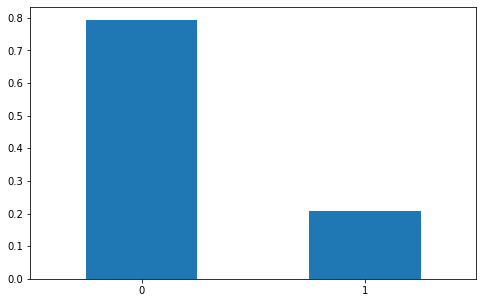

In [1109]:
#6. Just to also visualise the bins, we can see that the largest class size are role without data scientist in the job description
#This means firstly that we baseline for modelling is 79.3% and second is that we have imbalanced class sizes that we may need to consider. 
print(df_question_two.datascientist_flag.value_counts(normalize=True)*100)
df_question_two.datascientist_flag.value_counts(normalize=True).plot(kind='bar', rot=0, figsize=(8,5))

Lets now train a tfidVectorizer on the whole data set to see what features can separate data science vs. other roles that are flagged by the datascientist_flag variable.

In [283]:
#7. First lets create a bag of words variable based on company name, description, and location
df_question_two['bag_of_words'] = df_testing_two[['company', 'description','location']].stack().groupby(level=0).apply(','.join).str.lower()

#Lets also drop all digits in the bag of words as we are more interested in the types of job related things other than salary
#which we explored in question 1.
df_question_two['bag_of_words'] = df_question_two['bag_of_words'].str.replace("\d"," ")


#And now lets create our X and y Variables
X_question_two = df_question_two.bag_of_words
y_question_two = df_question_two.datascientist_flag

#And finally create a training and testing data set
X_desc_train, X_desc_test, y_desc_train, y_desc_test = train_test_split(X_question_two, y_question_two, random_state=42)

In [285]:
#8. Looking at the training and testing set, we have quite good sample sizes for our training and testing set (cf. our salary data)
#Therefore, we should be in a position to use cross_validation, which was a concern in question 1 when we only had 492 data points. 
print(X_desc_train.shape)
print(X_desc_test.shape)
print(y_desc_train.shape)
print(y_desc_test.shape)

(1743,)
(581,)
(1743,)
(581,)


In [704]:
#9. Let us now look at the top RELATIVE key-words in the data set. 
#First lets create a new list of stop_words to use. These are just standard lists that are appended
stop_words_q2 = list(list(punctuation) + list(ENGLISH_STOP_WORDS))

#Through an iterative
bespoke_stop_words_q2 = ['click', 
                          'apply',
                          'com',
                          'www',
                          'love',
                          'super',
                          'bonus',
                          'existing',
                          'keen',
                          'works',
                          'use',
                           'using',
                          'year',
                          'years',
                          'work',
                          'will',
                          'part',
                       'role',
                        'skills',
                        'including',
                        'australia',
                        'working',
                        'data',
                        'experience',
                        'business',
                        'new',
                        'ability',
                        'strong',
                        'provide',
                        'science',
                        'scientists',
                        'scientist']

final_stop_q2 = stop_words_q2 + bespoke_stop_words_q2

#As we are interested in RELATIVE importance of words in terms of the frequency they appear, I will use TfidfVectorizer
word_q2 = TfidfVectorizer(ngram_range=(1, 3), 
                          stop_words=final_stop_q2, 
                          max_features=400)

X_desc_train_tdm = word_q2.fit_transform(X_desc_train, y_desc_train)
X_desc_test_dtm = word_q2.transform(X_desc_test)

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
key_words_q2 = pd.DataFrame(X_desc_train_tdm.toarray(), columns=word_q2.get_feature_names(), index=X_desc_train.index)

I will use WordCloud, which is a simple library for creating wordclouds.

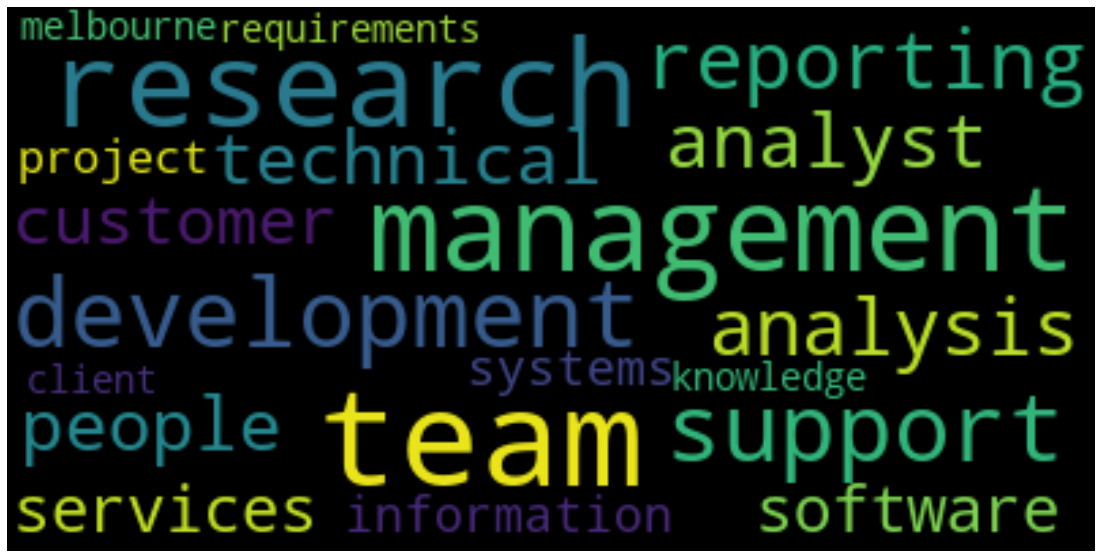

In [1080]:
#10. Combines testing dataset datascientist_flag column with words extracted using the TfidfVectorizer above
word_combined_datascience = key_words_q2.merge(df_question_two.datascientist_flag,left_index=True, right_index=True)
#This sums all column words for non_data science jobs
word_frequency_non_ds = pd.DataFrame(word_combined_datascience.loc[word_combined_datascience["datascientist_flag"] == 0].sum(axis=0)).drop('datascientist_flag')
word_frequency_non_ds.rename(columns={0:'Relative Frequency'}, inplace=True)
# word_frequency_non_ds.sort_values(by='Relative Frequency',ascending=False).head(20)

#Creates a dictionary of frequencies of top twenty words
relative_wf_non_ds_dict = word_frequency_non_ds.sort_values(by='Relative Frequency',ascending=False).head(20).to_dict()['Relative Frequency']
relative_wf_non_ds_dict

#Plots th
wordcloud_non_ds = WordCloud()
wordcloud_non_ds.generate_from_frequencies(frequencies=relative_wf_non_ds_dict, max_font_size=50)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud_non_ds, interpolation="bilinear")
# plt.title("Non-Data Science Roles: Top 20 Feature Words (by Relative Frequency)", fontdict={'fontsize': 24})
plt.axis("off")
plt.show()

In [676]:
# non_ds_plot = word_frequency_non_ds.sort_values(by='Relative Frequency',ascending=False).head(20)
# non_ds_plot.sort_values(by='Relative Frequency',ascending=True).plot(kind='barh', figsize=(10,10))

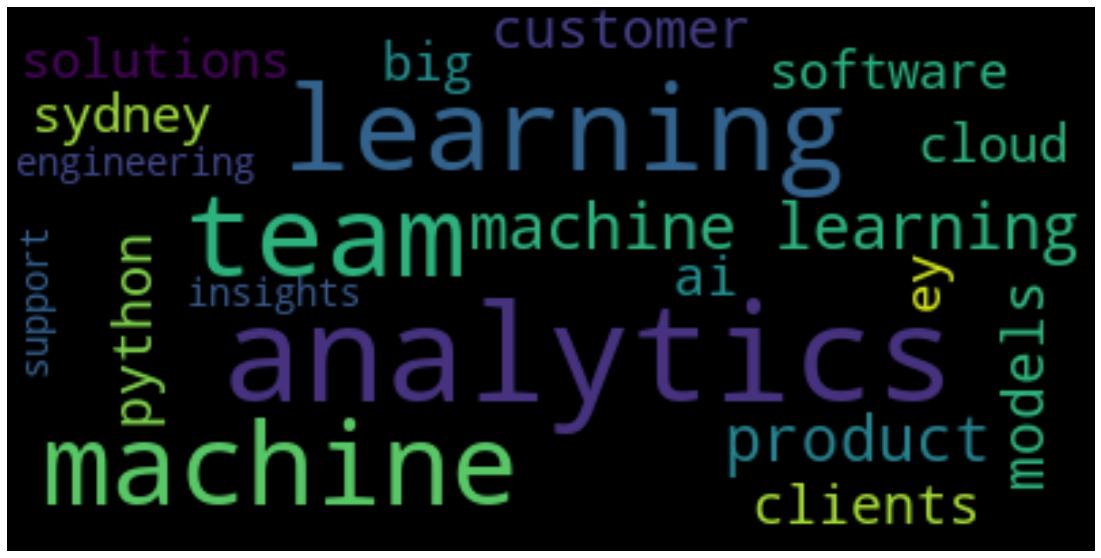

In [1079]:
#11. This sums all column words for data science jobs
word_frequency_ds = pd.DataFrame(word_combined_datascience.loc[word_combined_datascience["datascientist_flag"] == 1].sum(axis=0)).drop('datascientist_flag')
word_frequency_ds.rename(columns={0:'Relative Frequency'}, inplace=True)
# word_frequency_ds.sort_values(by='Relative Frequency',ascending=False).head(20)

#Creates a dictionary of frequencies of top twenty words
relative_wf_ds_dict = word_frequency_ds.sort_values(by='Relative Frequency',ascending=False).head(20).to_dict()['Relative Frequency']
# relative_wf_ds_dict

wordcloud_ds = WordCloud()
wordcloud_ds.generate_from_frequencies(frequencies=relative_wf_ds_dict, max_font_size=50)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud_ds, interpolation="bilinear")
# plt.title("Data Science Roles: Top 20 Feature Words (by Relative Frequency)", fontdict={'fontsize': 24})
plt.axis("off")
plt.show()

It would also be interesting to pull out the absolute count of the words associated with data scientist and non-data science roles although this would be less useful for current purposes. 

In [668]:
#12. This gets the index of the rows in the training set
indexs_of_ds_roles = df_question_two[df_question_two.datascientist_flag == 1].index
indexs_of_NON_ds_roles = df_question_two[df_question_two.datascientist_flag == 0].index
#And then uses these indexes to create a word count
out_ds = ' '.join(X_desc_train.loc[indexs_of_ds_roles].dropna())
out_NON_ds = ' '.join(X_desc_train.loc[indexs_of_NON_ds_roles].dropna())

C:\Users\matth\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """
C:\Users\matth\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


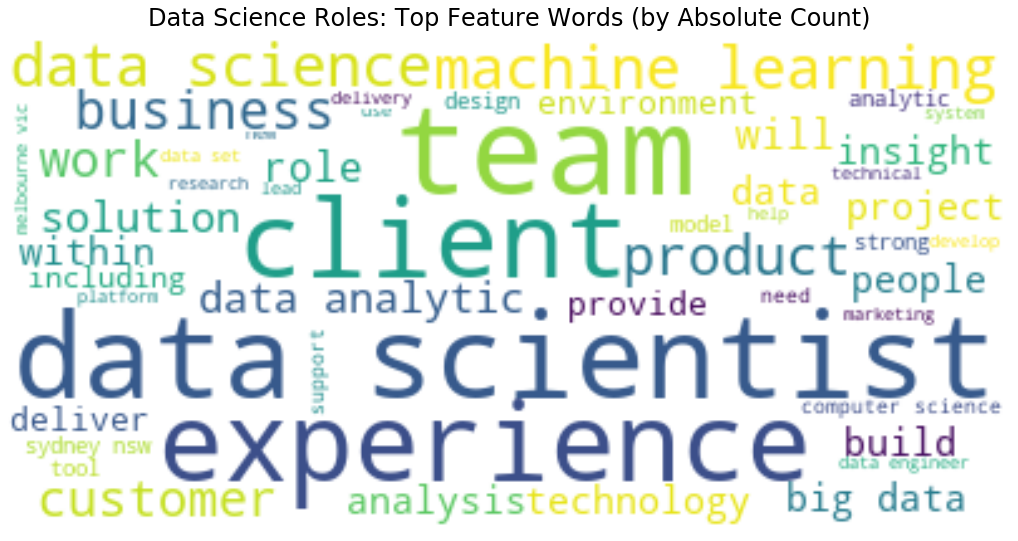

In [669]:
#13. We can then plot the wordcloud for Data Science roles
wordcloud_ds = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(out_ds)
plt.figure(figsize=(18,10))
plt.imshow(wordcloud_ds, interpolation="bilinear")
plt.title("Data Science Roles: Top Feature Words (by Absolute Count)", fontdict={'fontsize': 24})
plt.axis("off")
plt.show()

Unsurprisingly, among the key words being identified are data scientist, which is not really useful in terms of adding value in terms of identifying data-scientist type roles. Nethertheless, there is some interesting words that do emerge. 

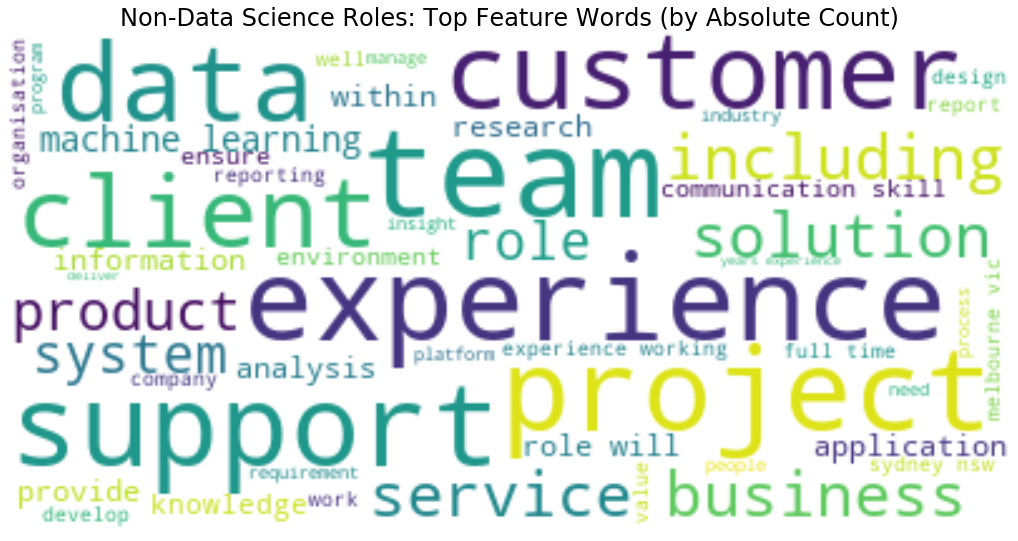

In [670]:
#14. We can also plot the wordcloud for **NON**-Data Science roles
wordcloud_NON_ds = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(out_NON_ds)
plt.figure(figsize=(18,10))
plt.imshow(wordcloud_NON_ds, interpolation="bilinear")
plt.title("Non-Data Science Roles: Top Feature Words (by Absolute Count)", fontdict={'fontsize': 24})
plt.axis("off")
plt.show()

#### Model Testing

Lets now try testing whether features in the job descriptions can distingush between data science and non-data science roles. For this, I will try Logistical Regression and Random Forests. 

##### Logistical Regression

In [996]:
# 1. First lets try a logistical regression.
log_pipe = make_pipeline(Normalizer(),LogisticRegression(random_state=42))
# log_regression = LogisticRegression(random_state=42)

#Pipe keys for passing hyperparamters to the pipeline were retrieved using log_pipe.get_params().keys()
log_regression_grid_params = {'logisticregression__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,50,100], 
                              #
                              'logisticregression__penalty': ['l1','l2'],
                              #picking the liblunear solver as default does not allow for l1 penalty
                             'logisticregression__solver': ['liblinear']}

grid_logistical_q2 = GridSearchCV(log_pipe, log_regression_grid_params, verbose=1, cv=10)
grid_logistical_q2.fit(X_desc_train_tdm, y_desc_train)

prediction_class_q2_lr = grid_logistical_q2.predict(X_desc_test_dtm)
prediction_class_q2_lr_prob = grid_logistical_q2.predict_proba(X_desc_test_dtm)

print("Q2 LOGISTICAL REGRESSION MODEL")
print("--------------------------------")
print("Mean of CV folds from each gridsearch:\n", grid_logistical_q2.cv_results_['mean_test_score'])
print("\nBest paramters are:\n", grid_logistical_q2.best_params_)
print("\nHighest Accuracy is:\n", grid_logistical_q2.best_score_)
print("\nStandard Deviation of Accuracy is:\n", grid_logistical_q2.cv_results_['std_test_score'][grid_logistical_q2.best_index_])
print("\nClassification Report:\n", classification_report(y_desc_test, prediction_class_q2_lr, target_names=["Non-Data Science","Data Scientist"]))
print("\nROC Score:\n", roc_auc_score(y_desc_test, prediction_class_q2_lr_prob[:, 1]))

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   36.9s finished


Q2 LOGISTICAL REGRESSION MODEL
--------------------------------
Mean of CV folds from each gridsearch:
 [0.79633169 0.79633169 0.79633169 0.79633169 0.79633169 0.79633169
 0.79633169 0.79633169 0.80436453 0.79633169 0.81582923 0.79747455
 0.81296223 0.80149425 0.81296223 0.80435468 0.81066667 0.80779967
 0.81354023 0.81009524 0.81411823 0.81410509 0.88236125 0.88582266
 0.89041051 0.89040394 0.89441708 0.89499836 0.90015107 0.89671921
 0.90130378 0.89901478 0.89901478 0.89557635 0.89215107 0.90016092]

Best paramters are:
 {'logisticregression__C': 20, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}

Highest Accuracy is:
 0.9013037766830869

Standard Deviation of Accuracy is:
 0.03180217651917378

Classification Report:
                   precision    recall  f1-score   support

Non-Data Science       0.95      0.93      0.94       455
  Data Scientist       0.77      0.82      0.79       126

        accuracy                           0.91       581
   

Text(0, 0.5, 'True Positive Rate (TPR)')

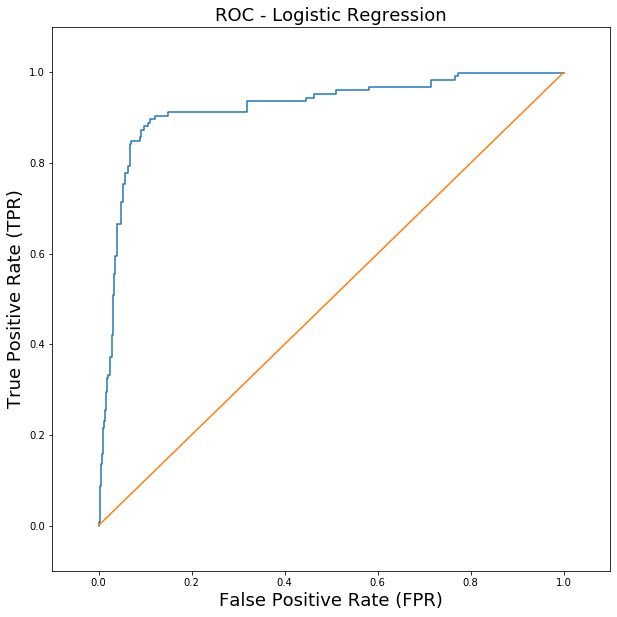

In [984]:
#To help visualise the performance of the logistical regression model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_desc_test, prediction_class_q2_lr_prob[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC - Logistic Regression', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)

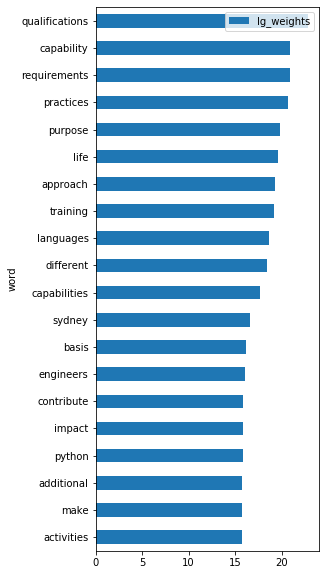

In [1113]:
#It is important to review the most important features in the logistical regression model. In this case, I will look at the 
#top 20 words with the highest weighted
feature_importance_log_r = pd.DataFrame(list(zip(word_q2.get_feature_names(),grid_logistical_q2.best_estimator_[-1].coef_[0])))
feature_importance_log_r.rename(columns={0:'word',1:'lg_weights'}, inplace=True)
top_20_log_r = feature_importance_log_r.sort_values(by='lg_weights', ascending=False).head(20)
top_20_log_r.sort_values(by='lg_weights', ascending=True).head(20).plot(x='word',y='lg_weights', kind='barh', figsize=(4,10))

##### Random Forests

In [1006]:
# Secomnd lets try Random Forests 
q2_rand_for = RandomForestClassifier(random_state=42)

q2_rand_for_grid_params = {'max_depth':[10,20,40],\
                           'criterion': ['gini', 'entropy'],\
                           'max_features': [40,50,60]}


grid_rand_for_q2 = GridSearchCV(q2_rand_for, q2_rand_for_grid_params, verbose=False, cv=10)
grid_rand_for_q2.fit(X_desc_train_tdm, y_desc_train)

prediction_class_q2_rf = grid_rand_for_q2.predict(X_desc_test_dtm)
prediction_class_q2_lr_rf = grid_rand_for_q2.predict_proba(X_desc_test_dtm)

print("Q2 RANDOM FORESTS MODEL")
print("--------------------------------")
print("Mean of CV folds from each gridsearch:\n", grid_rand_for_q2.cv_results_['mean_test_score'])
print("\nBest paramters are:\n", grid_rand_for_q2.best_params_)
print("\nHighest Accuracy is:\n", grid_rand_for_q2.best_score_)
print("\nStandard Deviation of Accuracy is:\n", grid_rand_for_q2.cv_results_['std_test_score'][grid_rand_for_q2.best_index_])
print("\nClassification Report:\n", classification_report(y_desc_test, prediction_class_q2_rf, target_names=["Non-Data Science","Data Scientist"]))
print("\nROC Score:\n", roc_auc_score(y_desc_test, prediction_class_q2_lr_rf[:, 1]))

Q2 RANDOM FORESTS MODEL
--------------------------------
Mean of CV folds from each gridsearch:
 [0.92885714 0.92772085 0.92541215 0.93116256 0.93231199 0.9323087
 0.93058128 0.93575041 0.93402299 0.93287028 0.93287685 0.93230213
 0.93287685 0.93803612 0.93459442 0.93287685 0.93803612 0.93459442]

Best paramters are:
 {'criterion': 'entropy', 'max_depth': 20, 'max_features': 50}

Highest Accuracy is:
 0.9380361247947455

Standard Deviation of Accuracy is:
 0.020014882257158674

Classification Report:
                   precision    recall  f1-score   support

Non-Data Science       0.94      0.99      0.97       455
  Data Scientist       0.97      0.78      0.86       126

        accuracy                           0.95       581
       macro avg       0.96      0.89      0.92       581
    weighted avg       0.95      0.95      0.94       581


ROC Score:
 0.9831501831501831


Text(0, 0.5, 'True Positive Rate (TPR)')

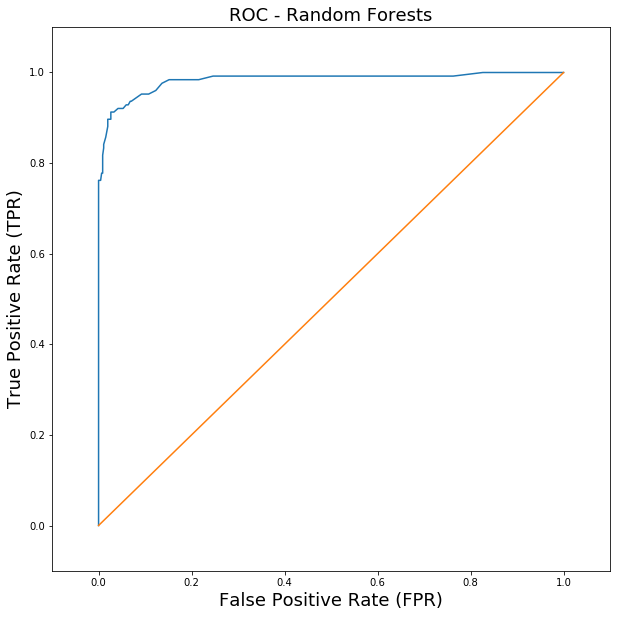

In [1007]:
#To help visualise the performance of the random forests model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_desc_test, prediction_class_q2_lr_rf[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC - Random Forests', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)

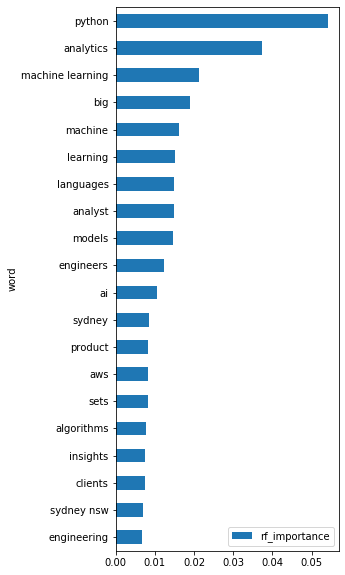

In [1112]:
feature_importance_rf = pd.DataFrame((zip(word_q2.get_feature_names(),grid_rand_for_q2.best_estimator_.feature_importances_)))
feature_importance_rf.rename(columns={0:'word',1:'rf_importance'}, inplace=True)
top_20_rf = feature_importance.sort_values(by='rf_importance', ascending=False).head(20)
top_20_rf.sort_values(by='rf_importance', ascending=True).plot(x='word',y='rf_importance', kind='barh', figsize=(4,10))

##### Takeaways
* Random Forests was the superior model in correctly classifying between data science and non-data science roles, with higher accuracy and ROC scores and lower variance in model performance.
* Random Forests feature importance is more interpretable on first inspection, with key features including:
  * **Python**: a key programming language used by data scientists that is also better for model deployment into work pipelines. 
  * **Analytics**: it is important to distingush between analysis and analytics as they are not the same thing. Analytics is more future-oriented while analysis more about analysing past information. Thus, the fact that random forests was able to extract this as a key feature is important and interpretable. 
  * **Machine Learning**: data science is about building models using ML and thus is another important feature that has been extracted. 
  * **Models**: data science is about building statistical models
  * **AI**: a core approach to modelling in data science
  * **AWS**: Amazon Web Services are important providers of cloud-computing infrastructure and computing that facilitate faster model training and deployment. 

END OF PROJECT
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


# Other Test Code
This is just some other test code I was playing around with based on discussions and one-to-ones in class to see what is occuring. This can be ignored for project purposes. 

#### Latent Dirichlet Allocation (LDA)

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation

pyLDAvis.enable_notebook()

In [462]:
lda_tf = LatentDirichletAllocation(n_components=13, random_state=42)
lda_tf.fit(X_train_dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=13, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [463]:
lda_tf_vis_tf = pyLDAvis.sklearn.prepare(lda_tf,X_train_dtm,vect)

C:\Users\matth\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [464]:
pyLDAvis.display(lda_tf_vis_tf)

#### Spacy

In [94]:
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
# load en_core_web_sm of English for vocabluary, syntax & entities
import en_core_web_sm
from spacy import displacy

In [933]:
test_job = df_testing.description[0]
test_job = nlp(test_job)

for x in test_job:
    if x.pos_ == 'PROPN':
        print(x.text, x.pos,x.pos_)

Edinburgh 96 PROPN
SA 96 PROPN
DST 96 PROPN
DST 96 PROPN
Defence 96 PROPN
DST 96 PROPN
DST 96 PROPN
Corporate 96 PROPN
Video 96 PROPN
Virtual 96 PROPN
Laboratory 96 PROPN
Technician 96 PROPN
Virtual 96 PROPN
Laboratory 96 PROPN
VL 96 PROPN
ICT 96 PROPN
Virtual 96 PROPN
Laboratory 96 PROPN
Artificial 96 PROPN
Intelligence 96 PROPN
Machine 96 PROPN
Learning 96 PROPN
Defense 96 PROPN
Artificial 96 PROPN
Intelligence 96 PROPN
Machine 96 PROPN
Defence 96 PROPN
ICT 96 PROPN
Virtual 96 PROPN
Laboratory 96 PROPN
Technician 96 PROPN
Virtual 96 PROPN
Laboratory 96 PROPN
Computing 96 PROPN
Capability 96 PROPN
Red 96 PROPN
Hat 96 PROPN
Enterprise 96 PROPN
Linux 96 PROPN
Microsoft 96 PROPN
Windows 96 PROPN
Virtual 96 PROPN
Laboratory 96 PROPN
Laboratory 96 PROPN
Computing 96 PROPN
Capability 96 PROPN
ICT 96 PROPN
ICT 96 PROPN


In [618]:
test_job = nlp(df_testing.description[0])
test_job.ents

(4/5, australian, sa dst, working hours, 15.4 per cent, microsoft)

##### PCA

In [479]:
from sklearn.decomposition import PCA,NMF
from sklearn.manifold import t_sne

C:\Users\matth\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [497]:
from sklearn.neighbors import NearestNeighbors

In [509]:
nn = NearestNeighbors??
# nn.fit(X_desc_train_tdm.todense().T)

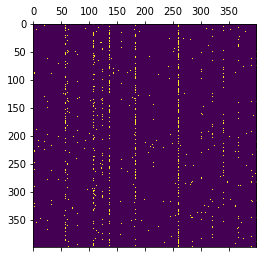

In [508]:
plt.matshow(nn.kneighbors_graph().todense())

In [510]:
X_train_dtm.todense()


matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.05086349, 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [516]:
from scipy.spatial.distance import pdist,squareform

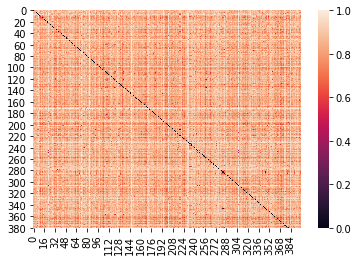

In [522]:
sns.heatmap(squareform(pdist(X_desc_train_tdm.todense().T,metric='cosine')))

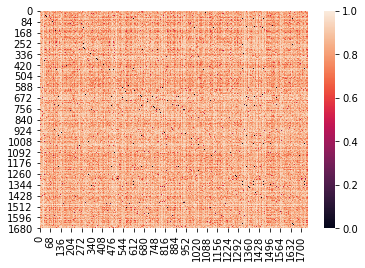

In [524]:
sns.heatmap(squareform(pdist(X_desc_train_tdm.todense(),metric='cosine')))

In [543]:
pd.DataFrame(X_desc_train_tdm.todense(),columns = ['docs_'+str(col) for col in range(X_desc_train_tdm.todense().shape[1])])

,docs_0,docs_1,docs_2,docs_3,docs_4,docs_5,docs_6,docs_7,docs_8,docs_9,...,docs_390,docs_391,docs_392,docs_393,docs_394,docs_395,docs_396,docs_397,docs_398,docs_399
0,0.000000,0.0,0.000000,0.000000,0.034333,0.0,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.041665,0.000000,0.000000,0.000000,0.0,0.00000,0.027917,0.000000
1,0.000000,0.0,0.000000,0.046232,0.000000,0.0,0.03873,0.043708,0.049573,0.000000,...,0.000000,0.000000,0.000000,0.083564,0.088430,0.105222,0.0,0.00000,0.033054,0.036844
2,0.000000,0.0,0.057599,0.000000,0.000000,0.0,0.00000,0.056197,0.000000,0.000000,...,0.054556,0.000000,0.000000,0.053721,0.000000,0.270577,0.0,0.00000,0.042499,0.047372
3,0.000000,0.0,0.000000,0.109931,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
4,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.090731,0.000000,...,0.000000,0.056967,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.060498,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.065338,0.000000,0.087709,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
1739,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.086377,...,0.000000,0.000000,0.000000,0.000000,0.075381,0.089695,0.0,0.00000,0.000000,0.000000
1740,0.000000,0.0,0.000000,0.041288,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.037315,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
1741,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.048432,0.000000


In [548]:
doc_dist = pd.DataFrame(squareform(pdist(X_desc_train_tdm.todense().T,metric='cosine')),columns=['docs_'+str(col) for col in range(X_desc_train_tdm.todense().shape[1])],index=['docs_'+str(col) for col in range(X_desc_train_tdm.todense().shape[1])])

In [610]:
word_q2.get_feature_names()

['able',
 'access',
 'achieve',
 'act',
 'activities',
 'additional',
 'advanced',
 'agile',
 'ai',
 'algorithms',
 'analyse',
 'analysis',
 'analyst',
 'analysts',
 'analytical',
 'analytics',
 'applicants',
 'application',
 'applications',
 'approach',
 'appropriate',
 'architecture',
 'areas',
 'asset',
 'assist',
 'attention',
 'au',
 'australian',
 'available',
 'aws',
 'azure',
 'background',
 'based',
 'basis',
 'benefits',
 'best',
 'better',
 'bi',
 'big',
 'bring',
 'build',
 'building',
 'candidate',
 'candidates',
 'capabilities',
 'capability',
 'care',
 'career',
 'challenges',
 'change',
 'client',
 'clients',
 'clinical',
 'close',
 'closely',
 'cloud',
 'code',
 'collaborate',
 'collaboration',
 'collaborative',
 'commercial',
 'committed',
 'communicate',
 'communication',
 'community',
 'companies',
 'company',
 'competitive',
 'complex',
 'compliance',
 'computer',
 'computer science',
 'computing',
 'considered',
 'consulting',
 'contact',
 'continuous',
 'contract

In [602]:
pd.DataFrame(squareform(pdist(X_desc_train_tdm.todense(),metric='cosine'))).sort_values(0)

,0,1,2,3,4,5,6,7,8,9,...,1733,1734,1735,1736,1737,1738,1739,1740,1741,1742
0,0.000000,0.718424,0.572481,0.933775,0.906903,0.877378,0.776119,0.822546,0.655815,0.712017,...,0.918538,0.968273,0.776081,0.742545,0.934554,0.897842,0.814637,0.910520,0.847517,0.791119
770,0.000000,0.718424,0.572481,0.933775,0.906903,0.877378,0.776119,0.822546,0.655815,0.712017,...,0.918538,0.968273,0.776081,0.742545,0.934554,0.897842,0.814637,0.910520,0.847517,0.791119
361,0.356761,0.670150,0.772442,0.948278,0.900941,0.909083,0.862443,0.828620,0.594250,0.667481,...,0.926706,0.913081,0.779476,0.727609,0.896553,0.834534,0.793772,0.925087,0.829521,0.875872
1107,0.478368,0.673310,0.360975,0.874489,0.816057,0.789230,0.747075,0.743090,0.911407,0.815953,...,0.835214,0.879173,0.732915,0.864553,0.913174,0.800722,0.694764,0.859756,0.785525,0.667414
427,0.478368,0.673310,0.360975,0.874489,0.816057,0.789230,0.747075,0.743090,0.911407,0.815953,...,0.835214,0.879173,0.732915,0.864553,0.913174,0.800722,0.694764,0.859756,0.785525,0.667414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,0.979764,0.877583,0.933942,0.808118,0.992523,0.816249,0.867903,0.857184,0.952463,0.926661,...,0.937496,0.918433,0.795927,0.875414,0.858679,0.914838,0.865082,0.960265,0.963402,0.903531
1695,0.984514,0.918911,0.970346,0.909507,0.937006,0.927085,0.927563,0.891411,0.944465,0.942811,...,0.920713,0.914188,0.921610,0.973314,0.949317,0.946161,0.996173,0.692907,0.925420,0.972751
627,0.984689,0.799864,0.879499,0.913308,0.676760,0.947455,0.934921,0.940836,0.900509,0.911283,...,0.916390,0.618456,0.907549,0.915383,0.945917,0.898316,0.849043,0.966800,0.885348,0.788575
561,0.984689,0.799864,0.879499,0.913308,0.676760,0.947455,0.934921,0.940836,0.900509,0.911283,...,0.916390,0.618456,0.907549,0.915383,0.945917,0.898316,0.849043,0.966800,0.885348,0.788575


In [551]:
doc_dist.sort_values('docs_0')

,docs_0,docs_1,docs_2,docs_3,docs_4,docs_5,docs_6,docs_7,docs_8,docs_9,...,docs_390,docs_391,docs_392,docs_393,docs_394,docs_395,docs_396,docs_397,docs_398,docs_399
docs_0,0.000000,0.848649,0.875069,0.922170,0.846322,0.866783,0.843892,0.852599,0.920445,0.916319,...,0.719367,0.841151,0.931556,0.837486,0.818452,0.888357,0.861692,0.842899,0.782518,0.737218
docs_369,0.669390,0.708069,0.699659,0.812251,0.704300,0.715727,0.696150,0.694856,0.819701,0.814337,...,0.707452,0.646361,0.805453,0.633133,0.692390,0.784678,0.763200,0.724438,0.569512,0.657099
docs_218,0.687292,0.868576,0.870347,0.871125,0.858544,0.821716,0.848302,0.818590,0.884205,0.860160,...,0.717863,0.716269,0.867475,0.770397,0.790627,0.791349,0.864335,0.823594,0.728381,0.701350
docs_265,0.695051,0.738462,0.682754,0.810005,0.766179,0.847595,0.772562,0.784023,0.913047,0.876666,...,0.777011,0.800424,0.835892,0.695985,0.736932,0.849911,0.783113,0.740361,0.674322,0.764271
docs_201,0.702929,0.803868,0.805122,0.825899,0.754309,0.830306,0.726079,0.777218,0.873874,0.797202,...,0.775838,0.748243,0.835865,0.839525,0.776410,0.809022,0.794520,0.762256,0.723441,0.727982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
docs_84,0.967301,1.000000,0.875161,0.975388,0.991295,0.986326,0.980452,1.000000,0.992842,0.838985,...,1.000000,0.992604,0.936963,0.997456,0.990442,0.994609,0.957260,0.992672,0.952849,0.951105
docs_147,0.973303,0.877956,0.954191,0.984853,0.997775,0.959657,0.908493,0.995384,0.990778,0.992612,...,0.993855,0.978374,0.976819,0.991835,0.970644,1.000000,0.972463,0.996516,0.920185,0.995017
docs_23,0.981703,0.964573,0.974261,0.897863,0.911932,0.975164,0.978170,0.981057,0.997349,0.980497,...,0.947071,0.938626,0.990035,0.852279,0.988793,0.981173,0.986025,0.946428,0.942801,0.955825
docs_173,0.983187,0.926473,0.997843,0.989452,0.972779,0.874106,0.948593,0.996569,0.826590,0.978062,...,0.980842,0.951746,0.992487,0.987572,0.986468,0.996102,0.992450,0.998328,0.816965,0.979262


In [580]:
pca = PCA()
pca.fit_transform(X_desc_train_tdm.todense()).shape

(1743, 400)

In [581]:
X_desc_train_tdm.todense().shape

(1743, 400)

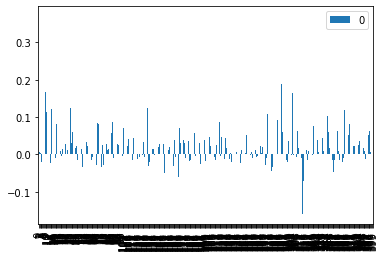

In [567]:
vect = np.zeros(400)
vect[0] = 1
pd.DataFrame(pca.inverse_transform(vect)).plot.bar()

In [578]:
vect

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [576]:
pd.DataFrame(squareform(pdist(pd.DataFrame(np.vstack([X_desc_train_tdm.todense(),pca.inverse_transform(vect).reshape(1,-1)]).T)))).sort_values(399)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
399,2.063408,2.007393,1.834529,2.071515,2.165532,1.623873,2.184260,2.233484,3.291209,2.405790,...,0.881494,2.064792,2.114876,2.207829,2.017731,2.284676,1.950531,1.872017,2.638355,0.000000
390,1.991531,1.969158,1.792194,2.095042,2.172052,1.595501,2.152791,2.183032,3.263593,2.386623,...,0.000000,2.054948,2.076195,2.148725,1.976106,2.237977,1.915679,1.839740,2.634909,0.881494
63,2.256589,2.224822,2.023961,2.258382,2.248313,1.997579,2.320080,2.406012,3.442802,2.630675,...,1.646839,2.178040,2.345819,2.325066,2.247260,2.503192,2.146908,2.125631,2.705683,1.544565
5,2.053958,1.763159,1.582460,1.940820,2.049746,0.000000,2.046846,2.104789,3.169765,2.251247,...,1.595501,2.020037,1.930693,1.970660,1.784988,2.208512,1.837988,1.671932,2.497173,1.623873
259,1.954019,1.743370,1.589366,1.956178,1.992847,1.511269,1.985056,1.967174,3.094791,2.189086,...,1.667606,1.898696,1.809689,1.947368,1.751355,2.184844,1.721802,1.568377,2.373957,1.707985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,4.105027,3.842827,3.940429,3.965409,4.027595,3.677658,4.143495,4.202861,4.824093,4.257225,...,4.003953,4.106750,4.058482,4.126158,4.042915,4.250428,4.028827,3.973089,4.481827,4.023269
147,4.207570,3.938985,3.988383,4.153484,4.221559,3.958174,4.084263,4.245579,4.848141,4.298779,...,4.074970,4.193688,4.121531,4.196858,4.068449,4.302227,4.069270,4.048517,4.402805,4.112140
15,4.260417,4.172191,4.191614,4.323011,4.285449,4.124515,3.931236,4.170925,4.847807,4.272119,...,4.235347,4.132387,4.256834,4.135609,4.116332,4.351886,4.135251,4.228880,4.288749,4.230111
230,4.688552,4.608302,4.540962,4.711735,4.451721,4.536583,4.420959,4.724069,5.305385,4.794126,...,4.574716,4.401826,4.646332,4.587692,4.533866,4.696543,4.594467,4.531115,4.862316,4.578906


In [569]:
X_desc_train_tdm.todense().T.shape

(400, 1743)

In [562]:
pca.inverse_transform(vect).reshape(1,-1).shape

(1, 1477)

In [529]:
from itertools import combinations

In [533]:
len(list(combinations(pd.DataFrame(X_desc_train_tdm.todense()).columns,2)))

79800

In [535]:
len(pdist(X_desc_train_tdm.todense().T,metric='cosine'))

79800

In [541]:
# pdist(X_desc_train_tdm.todense(),metric='cosine')

pd.DataFrame(squareform(pdist(X_desc_train_tdm.todense().T,metric='cosine')))
#              ,columns=list(combinations(pd.DataFrame(X_desc_train_tdm.todense()).columns,2)))

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.000000,0.848649,0.875069,0.922170,0.846322,0.866783,0.843892,0.852599,0.920445,0.916319,...,0.719367,0.841151,0.931556,0.837486,0.818452,0.888357,0.861692,0.842899,0.782518,0.737218
1,0.848649,0.000000,0.810320,0.932793,0.872934,0.850354,0.830357,0.882333,0.949722,0.924818,...,0.905899,0.843995,0.802558,0.899865,0.893468,0.957146,0.814847,0.837019,0.767685,0.880762
2,0.875069,0.810320,0.000000,0.903259,0.878402,0.811913,0.839048,0.868811,0.976523,0.877449,...,0.862205,0.853218,0.818787,0.847130,0.820617,0.920503,0.861267,0.907475,0.737608,0.835586
3,0.922170,0.932793,0.903259,0.000000,0.805500,0.899568,0.904147,0.910961,0.982695,0.982153,...,0.912940,0.961466,0.899553,0.942997,0.912098,0.965787,0.931480,0.875599,0.897402,0.841142
4,0.846322,0.872934,0.878402,0.805500,0.000000,0.912788,0.823054,0.899658,0.963552,0.958731,...,0.903293,0.812552,0.920466,0.896876,0.907774,0.939489,0.885505,0.846547,0.862061,0.850071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.888357,0.957146,0.920503,0.965787,0.939489,0.924763,0.913988,0.807794,0.930264,0.943843,...,0.845524,0.880794,0.961644,0.875594,0.854705,0.000000,0.945136,0.925679,0.837522,0.841624
396,0.861692,0.814847,0.861267,0.931480,0.885505,0.940071,0.836412,0.881719,0.930204,0.903537,...,0.867313,0.764547,0.886637,0.862183,0.951869,0.945136,0.000000,0.839209,0.844187,0.840559
397,0.842899,0.837019,0.907475,0.875599,0.846547,0.889262,0.852198,0.828133,0.968509,0.942536,...,0.894314,0.833944,0.872812,0.869561,0.848233,0.925679,0.839209,0.000000,0.781708,0.857843
398,0.782518,0.767685,0.737608,0.897402,0.862061,0.762515,0.846651,0.855374,0.876687,0.815237,...,0.812601,0.791801,0.726931,0.678775,0.757677,0.837522,0.844187,0.781708,0.000000,0.788522
